# Source Code Labeling using CodeBERT & Graph Attention Neural Network

In [1]:
import os
import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, Dataset
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import sys
import torch
import shutil
import clang.cindex
import subprocess
import pickle
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch_geometric.nn
import numpy
from collections import defaultdict

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print(f"GPU Dev name: {torch.cuda.get_device_name(0)}")

GPU Dev name: NVIDIA GeForce RTX 4070 Laptop GPU


In [3]:
!nvidia-smi

Fri Sep 26 23:56:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.75                 Driver Version: 566.24         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P0             10W /  140W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
!wget https://samate.nist.gov/SARD/downloads/test-suites/2017-10-01-juliet-test-suite-for-c-cplusplus-v1-3.zip -O juliet.zip

--2025-09-07 20:51:37--  https://samate.nist.gov/SARD/downloads/test-suites/2017-10-01-juliet-test-suite-for-c-cplusplus-v1-3.zip
Resolving samate.nist.gov (samate.nist.gov)... 129.6.13.19, 2610:20:6005:13::19
Connecting to samate.nist.gov (samate.nist.gov)|129.6.13.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152957342 (146M) [application/zip]
Saving to: ‘juliet.zip’

juliet.zip          100%[===================>] 145.87M  7.47MB/s    in 16s     

2025-09-07 20:51:53 (9.41 MB/s) - ‘juliet.zip’ saved [152957342/152957342]



In [6]:
![ -d "unzipped_testcases" ] && echo 'unzipped directory already exists and delete it' && rm -rf unzipped_testcases

In [7]:
!mkdir unzipped_testcases && unzip juliet.zip -d unzipped_testcases

Archive:  juliet.zip
   creating: unzipped_testcases/C/
  inflating: unzipped_testcases/C/Makefile  
  inflating: unzipped_testcases/C/run_analysis_example_tool.py  
   creating: unzipped_testcases/C/doc/
  inflating: unzipped_testcases/C/doc/Juliet Test Suite v1.2 for C_Cpp - User Guide.pdf  
  inflating: unzipped_testcases/C/doc/Juliet_1.3_Changes_From_1.2.pdf  
  inflating: unzipped_testcases/C/doc/changelog_Juliet_C_Cpp.txt  
  inflating: unzipped_testcases/C/compile_all.bat  
   creating: unzipped_testcases/C/testcases/
   creating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/
   creating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_char_rand_32.c  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_wchar_t_rand_67b.c  
  inflating: unzipped_testcases/C/testcases/C

  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_char_connect_socket_83a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_char_listen_socket_84.h  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_char_connect_socket_66b.c  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_char_listen_socket_63a.c  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_wchar_t_fgets_51a.c  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_char_fscanf_61a.c  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_wchar_t_fgets_67b.c  
  inflating: 

  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_wchar_t_fgets_65a.c  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_wchar_t_connect_socket_53d.c  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__new_char_connect_socket_34.cpp  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_wchar_t_fscanf_81_goodB2G.cpp  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_char_fscanf_16.c  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_char_fscanf_22b.c  
  inflating: unzipped_testcases/C/testcases/CWE789_Uncontrolled_Mem_Alloc/s01/CWE789_Uncontrolled_Mem_Alloc__malloc_char_connect_socket_11.c  
  inflating

  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__connect_socket_memcpy_84_goodG2B.cpp  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__fgets_memmove_44.c  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__connect_socket_memcpy_66b.c  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__connect_socket_strncpy_09.c  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__connect_socket_memcpy_72a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__connect_socket_strncpy_73b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__fgets_memm

  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__fscanf_malloc_17.c  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__fgets_memcpy_65b.c  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__fscanf_malloc_07.c  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__connect_socket_memcpy_82.h  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__connect_socket_malloc_44.c  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__connect_socket_strncpy_84_goodG2B.cpp  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s01/CWE194_Unexpected_Sign_Extension__fgets_memcpy_51b.c  
  inflating: 

  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s02/CWE194_Unexpected_Sign_Extension__rand_memcpy_61b.c  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s02/CWE194_Unexpected_Sign_Extension__listen_socket_memcpy_43.cpp  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s02/CWE194_Unexpected_Sign_Extension__negative_strncpy_81_bad.cpp  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s02/CWE194_Unexpected_Sign_Extension__listen_socket_memmove_32.c  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s02/CWE194_Unexpected_Sign_Extension__listen_socket_strncpy_41.c  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s02/CWE194_Unexpected_Sign_Extension__negative_memmove_67b.c  
  inflating: unzipped_testcases/C/testcases/CWE194_Unexpected_Sign_Extension/s02/CWE194_Unexpected_Sign_Extension__listen_socket_memcpy_73a.cpp  
 

   creating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/
   creating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s03/
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s03/CWE78_OS_Command_Injection__char_file_popen_73a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s03/CWE78_OS_Command_Injection__char_file_system_68b.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s03/CWE78_OS_Command_Injection__char_file_w32_execvp_21.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s03/CWE78_OS_Command_Injection__char_file_system_15.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s03/CWE78_OS_Command_Injection__char_file_w32_execvp_83_bad.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s03/CWE78_OS_Command_Injection__char_file_w32_execvp_44.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injectio

  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s09/CWE78_OS_Command_Injection__wchar_t_listen_socket_w32_spawnvp_10.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s09/CWE78_OS_Command_Injection__wchar_t_listen_socket_w32_spawnvp_13.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s09/CWE78_OS_Command_Injection__wchar_t_listen_socket_w32_execv_22a.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s09/CWE78_OS_Command_Injection__wchar_t_listen_socket_w32_spawnlp_82_goodG2B.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s09/CWE78_OS_Command_Injection__wchar_t_listen_socket_w32_spawnvp_51b.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s09/CWE78_OS_Command_Injection__wchar_t_listen_socket_w32_spawnlp_54d.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s09/CWE78_OS_Command_Injection__wchar_t_listen_socket_

  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s07/CWE78_OS_Command_Injection__wchar_t_file_execlp_63a.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s07/CWE78_OS_Command_Injection__wchar_t_environment_w32_spawnv_82a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s07/CWE78_OS_Command_Injection__wchar_t_environment_w32_spawnv_83_goodG2B.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s07/CWE78_OS_Command_Injection__wchar_t_environment_popen_84_goodG2B.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s07/CWE78_OS_Command_Injection__wchar_t_file_popen_68a.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s07/CWE78_OS_Command_Injection__wchar_t_file_execlp_18.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s07/CWE78_OS_Command_Injection__wchar_t_environment_w32_execv_43.cpp  
  inflating: unzipped_test

  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s01/CWE78_OS_Command_Injection__char_console_execl_34.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s01/CWE78_OS_Command_Injection__char_console_execlp_21.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s01/CWE78_OS_Command_Injection__char_connect_socket_w32_execvp_21.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s01/CWE78_OS_Command_Injection__char_connect_socket_w32_spawnv_66b.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s01/CWE78_OS_Command_Injection__char_connect_socket_popen_16.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s01/CWE78_OS_Command_Injection__char_connect_socket_w32_spawnvp_73a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s01/CWE78_OS_Command_Injection__char_console_execlp_63a.c  
  inflating: unzipped_testcases/C/testcases/CW

  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s05/CWE78_OS_Command_Injection__char_listen_socket_w32_spawnv_82a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s05/CWE78_OS_Command_Injection__wchar_t_connect_socket_popen_83a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s05/CWE78_OS_Command_Injection__wchar_t_connect_socket_w32_spawnv_67a.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s05/CWE78_OS_Command_Injection__char_listen_socket_w32_spawnvp_13.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s05/CWE78_OS_Command_Injection__wchar_t_connect_socket_execl_54a.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s05/CWE78_OS_Command_Injection__wchar_t_connect_socket_w32_execvp_16.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s05/CWE78_OS_Command_Injection__wchar_t_connect_socket_popen_81_goodG2B.cp

  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s04/CWE78_OS_Command_Injection__char_listen_socket_execlp_43.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s04/CWE78_OS_Command_Injection__char_file_w32_spawnv_09.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s04/CWE78_OS_Command_Injection__char_listen_socket_execlp_84.h  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s04/CWE78_OS_Command_Injection__char_file_w32_spawnvp_53b.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s04/CWE78_OS_Command_Injection__char_listen_socket_popen_54a.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s04/CWE78_OS_Command_Injection__char_listen_socket_popen_84a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s04/CWE78_OS_Command_Injection__char_file_w32_spawnlp_84_goodG2B.cpp  
  inflating: unzipped_testcases/C/testcases/CW

  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s08/CWE78_OS_Command_Injection__wchar_t_listen_socket_execlp_74b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s08/CWE78_OS_Command_Injection__wchar_t_file_w32_spawnv_74b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s08/CWE78_OS_Command_Injection__wchar_t_listen_socket_execlp_82.h  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s08/CWE78_OS_Command_Injection__wchar_t_listen_socket_w32spawnl_13.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s08/CWE78_OS_Command_Injection__wchar_t_listen_socket_popen_44.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s08/CWE78_OS_Command_Injection__wchar_t_listen_socket_w32_execvp_51b.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s08/CWE78_OS_Command_Injection__wchar_t_listen_socket_w32spawnl_45.c  
  inflating: unz

  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s06/CWE78_OS_Command_Injection__wchar_t_console_system_03.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s06/CWE78_OS_Command_Injection__wchar_t_console_w32_execvp_03.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s06/CWE78_OS_Command_Injection__wchar_t_console_execl_62a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s06/CWE78_OS_Command_Injection__wchar_t_console_popen_54e.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s06/CWE78_OS_Command_Injection__wchar_t_environment_execl_52b.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s06/CWE78_OS_Command_Injection__wchar_t_console_execl_67b.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s06/CWE78_OS_Command_Injection__wchar_t_console_w32_spawnvp_74a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_O

  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s02/CWE78_OS_Command_Injection__char_console_w32_spawnlp_18.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s02/CWE78_OS_Command_Injection__char_environment_execl_82_bad.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s02/CWE78_OS_Command_Injection__char_console_w32_spawnv_33.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s02/CWE78_OS_Command_Injection__char_console_w32_execv_64a.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s02/CWE78_OS_Command_Injection__char_console_w32_spawnv_84.h  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s02/CWE78_OS_Command_Injection__char_environment_execlp_68b.c  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Command_Injection/s02/CWE78_OS_Command_Injection__char_console_system_33.cpp  
  inflating: unzipped_testcases/C/testcases/CWE78_OS_Co

  inflating: unzipped_testcases/C/testcases/CWE226_Sensitive_Information_Uncleared_Before_Release/CWE226_Sensitive_Information_Uncleared_Before_Release__w32_char_alloca_07.c  
  inflating: unzipped_testcases/C/testcases/CWE226_Sensitive_Information_Uncleared_Before_Release/CWE226_Sensitive_Information_Uncleared_Before_Release__w32_char_alloca_14.c  
  inflating: unzipped_testcases/C/testcases/CWE226_Sensitive_Information_Uncleared_Before_Release/CWE226_Sensitive_Information_Uncleared_Before_Release__w32_char_declare_06.c  
  inflating: unzipped_testcases/C/testcases/CWE226_Sensitive_Information_Uncleared_Before_Release/CWE226_Sensitive_Information_Uncleared_Before_Release__w32_char_alloca_12.c  
  inflating: unzipped_testcases/C/testcases/CWE226_Sensitive_Information_Uncleared_Before_Release/CWE226_Sensitive_Information_Uncleared_Before_Release__w32_wchar_t_declare_05.c  
  inflating: unzipped_testcases/C/testcases/CWE226_Sensitive_Information_Uncleared_Before_Release/CWE226_Sensitive_

  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s03/CWE127_Buffer_Underread__new_wchar_t_loop_05.cpp  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s03/CWE127_Buffer_Underread__new_wchar_t_memmove_18.cpp  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s03/CWE127_Buffer_Underread__wchar_t_alloca_cpy_05.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s03/CWE127_Buffer_Underread__new_char_memmove_53c.cpp  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s03/CWE127_Buffer_Underread__wchar_t_alloca_cpy_10.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s03/CWE127_Buffer_Underread__new_wchar_t_memcpy_08.cpp  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s03/CWE127_Buffer_Underread__new_wchar_t_loop_83.h  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s03/CWE127_Buffer_Underread__new_char_loop_84a.cpp  
  inflating: u

  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s01/CWE127_Buffer_Underread__CWE839_connect_socket_82a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s01/CWE127_Buffer_Underread__char_declare_loop_54b.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s01/CWE127_Buffer_Underread__char_alloca_loop_67a.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s01/CWE127_Buffer_Underread__char_alloca_loop_54c.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s01/CWE127_Buffer_Underread__CWE839_listen_socket_83.h  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s01/CWE127_Buffer_Underread__CWE839_fscanf_04.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s01/CWE127_Buffer_Underread__CWE839_fgets_54d.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s01/CWE127_Buffer_Underread__char_declare_memcpy_74b.cpp  
  inflating: unz

  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s02/CWE127_Buffer_Underread__malloc_char_memcpy_53a.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s02/CWE127_Buffer_Underread__malloc_char_cpy_67b.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s02/CWE127_Buffer_Underread__malloc_char_loop_45.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s02/CWE127_Buffer_Underread__malloc_char_loop_84a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s02/CWE127_Buffer_Underread__malloc_char_memcpy_81_goodG2B.cpp  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s02/CWE127_Buffer_Underread__malloc_char_loop_65b.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s02/CWE127_Buffer_Underread__malloc_char_loop_03.c  
  inflating: unzipped_testcases/C/testcases/CWE127_Buffer_Underread/s02/CWE127_Buffer_Underread__malloc_wchar_t_cpy_03.c  
  inflating

  inflating: unzipped_testcases/C/testcases/CWE843_Type_Confusion/CWE843_Type_Confusion__short_10.c  
  inflating: unzipped_testcases/C/testcases/CWE843_Type_Confusion/CWE843_Type_Confusion__short_54e.c  
  inflating: unzipped_testcases/C/testcases/CWE843_Type_Confusion/CWE843_Type_Confusion__short_03.c  
  inflating: unzipped_testcases/C/testcases/CWE843_Type_Confusion/CWE843_Type_Confusion__short_73a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE843_Type_Confusion/CWE843_Type_Confusion__short_74b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE843_Type_Confusion/CWE843_Type_Confusion__char_81.h  
  inflating: unzipped_testcases/C/testcases/CWE843_Type_Confusion/CWE843_Type_Confusion__short_54d.c  
  inflating: unzipped_testcases/C/testcases/CWE843_Type_Confusion/CWE843_Type_Confusion__char_45.c  
  inflating: unzipped_testcases/C/testcases/CWE843_Type_Confusion/Makefile  
  inflating: unzipped_testcases/C/testcases/CWE843_Type_Confusion/CWE843_Type_Confusion__short_73b.cp

  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s03/CWE762_Mismatched_Memory_Management_Routines__delete_int_calloc_82_goodG2B.cpp  
  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s03/CWE762_Mismatched_Memory_Management_Routines__delete_int64_t_malloc_54a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s03/CWE762_Mismatched_Memory_Management_Routines__delete_int64_t_malloc_81_goodB2G.cpp  
  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s03/CWE762_Mismatched_Memory_Management_Routines__delete_int64_t_calloc_52a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s03/CWE762_Mismatched_Memory_Management_Routines__delete_char_realloc_54d.cpp  
  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s03/CWE762_Mismatched_Memory_Management_Routines

  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s01/CWE762_Mismatched_Memory_Management_Routines__delete_array_int64_t_malloc_84_bad.cpp  
  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s01/CWE762_Mismatched_Memory_Management_Routines__delete_array_int64_t_calloc_16.cpp  
  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s01/CWE762_Mismatched_Memory_Management_Routines__delete_array_char_malloc_84_goodB2G.cpp  
  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s01/CWE762_Mismatched_Memory_Management_Routines__delete_array_int64_t_realloc_06.cpp  
  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s01/CWE762_Mismatched_Memory_Management_Routines__delete_array_int64_t_calloc_21.cpp  
  inflating: unzipped_testcases/C/testcases/CWE762_Mismatched_Memory_Management_Routines/s01/CWE762_Mismatched

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s04/CWE124_Buffer_Underwrite__wchar_t_alloca_ncpy_51b.c  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s04/CWE124_Buffer_Underwrite__wchar_t_declare_cpy_68b.c  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s04/CWE124_Buffer_Underwrite__wchar_t_declare_memmove_81a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s04/CWE124_Buffer_Underwrite__wchar_t_declare_cpy_66a.c  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s04/CWE124_Buffer_Underwrite__wchar_t_declare_ncpy_06.c  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s04/CWE124_Buffer_Underwrite__wchar_t_declare_cpy_72a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s04/CWE124_Buffer_Underwrite__wchar_t_alloca_ncpy_72b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s04/CWE124_Buffer_Underwrite__w

  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s02/CWE124_Buffer_Underwrite__malloc_char_memcpy_44.c  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s02/CWE124_Buffer_Underwrite__malloc_wchar_t_memcpy_61a.c  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s02/CWE124_Buffer_Underwrite__malloc_char_memcpy_31.c  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s02/CWE124_Buffer_Underwrite__malloc_char_loop_13.c  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s02/CWE124_Buffer_Underwrite__malloc_wchar_t_memcpy_54e.c  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s02/CWE124_Buffer_Underwrite__malloc_wchar_t_memcpy_44.c  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s02/CWE124_Buffer_Underwrite__malloc_char_memmove_51b.c  
  inflating: unzipped_testcases/C/testcases/CWE124_Buffer_Underwrite/s02/CWE124_Buffer_Underwrite__malloc_wchar_t_

  inflating: unzipped_testcases/C/testcases/CWE680_Integer_Overflow_to_Buffer_Overflow/CWE680_Integer_Overflow_to_Buffer_Overflow__new_rand_22b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE680_Integer_Overflow_to_Buffer_Overflow/CWE680_Integer_Overflow_to_Buffer_Overflow__malloc_connect_socket_34.c  
  inflating: unzipped_testcases/C/testcases/CWE680_Integer_Overflow_to_Buffer_Overflow/CWE680_Integer_Overflow_to_Buffer_Overflow__new_fgets_11.cpp  
  inflating: unzipped_testcases/C/testcases/CWE680_Integer_Overflow_to_Buffer_Overflow/CWE680_Integer_Overflow_to_Buffer_Overflow__malloc_fscanf_07.c  
  inflating: unzipped_testcases/C/testcases/CWE680_Integer_Overflow_to_Buffer_Overflow/CWE680_Integer_Overflow_to_Buffer_Overflow__malloc_listen_socket_42.c  
  inflating: unzipped_testcases/C/testcases/CWE680_Integer_Overflow_to_Buffer_Overflow/CWE680_Integer_Overflow_to_Buffer_Overflow__malloc_fgets_65a.c  
  inflating: unzipped_testcases/C/testcases/CWE680_Integer_Overflow_to_Buffer

  inflating: unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_environment_72b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_wchar_t_connect_socket_15.c  
  inflating: unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_wchar_t_connect_socket_68b.c  
  inflating: unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_wchar_t_relativePath_02.c  
  inflating: unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_wchar_t_console_54d.c  
  inflating: unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_file_18.c  
  inflating: unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_console_52b.c  
  inflating: unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_wchar_t_connect_socket_81a.cpp  
  inflating: unzipped_testcas

  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s03/CWE36_Absolute_Path_Traversal__wchar_t_connect_socket_fopen_16.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s03/CWE36_Absolute_Path_Traversal__wchar_t_connect_socket_open_12.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s03/CWE36_Absolute_Path_Traversal__wchar_t_console_w32CreateFile_51b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s03/CWE36_Absolute_Path_Traversal__wchar_t_connect_socket_fopen_01.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s03/CWE36_Absolute_Path_Traversal__wchar_t_environment_fopen_67a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s03/CWE36_Absolute_Path_Traversal__wchar_t_connect_socket_ifstream_41.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s03/CWE36_Absolute_Path_Traversal__wchar_t

  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s01/CWE36_Absolute_Path_Traversal__char_console_ofstream_31.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s01/CWE36_Absolute_Path_Traversal__char_console_ifstream_53a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s01/CWE36_Absolute_Path_Traversal__char_environment_ifstream_21.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s01/CWE36_Absolute_Path_Traversal__char_connect_socket_fopen_52c.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s01/CWE36_Absolute_Path_Traversal__char_console_ifstream_65b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s01/CWE36_Absolute_Path_Traversal__char_console_ofstream_73b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s01/CWE36_Absolute_Path_Traversal__char_environment_ifstream_61b.cpp  
  i

  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s04/CWE36_Absolute_Path_Traversal__wchar_t_file_ifstream_53b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s04/CWE36_Absolute_Path_Traversal__wchar_t_environment_ifstream_17.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s04/CWE36_Absolute_Path_Traversal__wchar_t_listen_socket_ifstream_68a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s04/CWE36_Absolute_Path_Traversal__wchar_t_environment_ofstream_82.h  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s04/CWE36_Absolute_Path_Traversal__wchar_t_file_ofstream_62b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s04/CWE36_Absolute_Path_Traversal__wchar_t_environment_w32CreateFile_53a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s04/CWE36_Absolute_Path_Traversal__wchar_t_enviro

  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s02/CWE36_Absolute_Path_Traversal__char_environment_ofstream_65b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s02/CWE36_Absolute_Path_Traversal__char_environment_ofstream_51a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s02/CWE36_Absolute_Path_Traversal__char_environment_ofstream_14.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s02/CWE36_Absolute_Path_Traversal__char_environment_ofstream_52c.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s02/CWE36_Absolute_Path_Traversal__char_file_open_04.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s02/CWE36_Absolute_Path_Traversal__char_file_w32CreateFile_65b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE36_Absolute_Path_Traversal/s02/CWE36_Absolute_Path_Traversal__char_environment_ofstream_12.cpp  
 

  inflating: unzipped_testcases/C/testcases/CWE606_Unchecked_Loop_Condition/CWE606_Unchecked_Loop_Condition__wchar_t_connect_socket_44.c  
  inflating: unzipped_testcases/C/testcases/CWE606_Unchecked_Loop_Condition/CWE606_Unchecked_Loop_Condition__char_connect_socket_14.c  
  inflating: unzipped_testcases/C/testcases/CWE606_Unchecked_Loop_Condition/CWE606_Unchecked_Loop_Condition__char_file_74a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE606_Unchecked_Loop_Condition/CWE606_Unchecked_Loop_Condition__char_console_15.c  
  inflating: unzipped_testcases/C/testcases/CWE606_Unchecked_Loop_Condition/CWE606_Unchecked_Loop_Condition__char_listen_socket_84_goodB2G.cpp  
  inflating: unzipped_testcases/C/testcases/CWE606_Unchecked_Loop_Condition/CWE606_Unchecked_Loop_Condition__wchar_t_console_61b.c  
  inflating: unzipped_testcases/C/testcases/CWE606_Unchecked_Loop_Condition/CWE606_Unchecked_Loop_Condition__char_connect_socket_72a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE606

  inflating: unzipped_testcases/C/testcases/CWE416_Use_After_Free/CWE416_Use_After_Free__malloc_free_char_05.c  
  inflating: unzipped_testcases/C/testcases/CWE416_Use_After_Free/CWE416_Use_After_Free__new_delete_array_int_63b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE416_Use_After_Free/CWE416_Use_After_Free__malloc_free_wchar_t_63a.c  
  inflating: unzipped_testcases/C/testcases/CWE416_Use_After_Free/CWE416_Use_After_Free__malloc_free_char_08.c  
  inflating: unzipped_testcases/C/testcases/CWE416_Use_After_Free/CWE416_Use_After_Free__malloc_free_int64_t_08.c  
  inflating: unzipped_testcases/C/testcases/CWE416_Use_After_Free/CWE416_Use_After_Free__new_delete_struct_16.cpp  
  inflating: unzipped_testcases/C/testcases/CWE416_Use_After_Free/CWE416_Use_After_Free__new_delete_class_01.cpp  
  inflating: unzipped_testcases/C/testcases/CWE416_Use_After_Free/CWE416_Use_After_Free__new_delete_array_int64_t_08.cpp  
  inflating: unzipped_testcases/C/testcases/CWE416_Use_After_Free/C

  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s03/CWE134_Uncontrolled_Format_String__wchar_t_connect_socket_fprintf_12.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s03/CWE134_Uncontrolled_Format_String__char_listen_socket_vprintf_53a.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s03/CWE134_Uncontrolled_Format_String__char_listen_socket_w32_vsnprintf_82.h  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s03/CWE134_Uncontrolled_Format_String__wchar_t_connect_socket_snprintf_32.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s03/CWE134_Uncontrolled_Format_String__wchar_t_connect_socket_fprintf_67a.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s03/CWE134_Uncontrolled_Format_String__char_listen_socket_vfprintf_54e.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_

  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s01/CWE134_Uncontrolled_Format_String__char_console_fprintf_14.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s01/CWE134_Uncontrolled_Format_String__char_console_snprintf_32.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s01/CWE134_Uncontrolled_Format_String__char_connect_socket_w32_vsnprintf_13.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s01/CWE134_Uncontrolled_Format_String__char_connect_socket_fprintf_54d.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s01/CWE134_Uncontrolled_Format_String__char_connect_socket_printf_81_goodB2G.cpp  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s01/CWE134_Uncontrolled_Format_String__char_console_vfprintf_67a.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s01/CWE134_U

  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s05/CWE134_Uncontrolled_Format_String__wchar_t_environment_snprintf_33.cpp  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s05/CWE134_Uncontrolled_Format_String__wchar_t_listen_socket_fprintf_31.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s05/CWE134_Uncontrolled_Format_String__wchar_t_environment_w32_vsnprintf_84a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s05/CWE134_Uncontrolled_Format_String__wchar_t_file_vfprintf_66a.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s05/CWE134_Uncontrolled_Format_String__wchar_t_file_fprintf_54e.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s05/CWE134_Uncontrolled_Format_String__wchar_t_file_printf_17.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s05/CWE134_Unco

  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s04/CWE134_Uncontrolled_Format_String__wchar_t_connect_socket_w32_vsnprintf_08.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s04/CWE134_Uncontrolled_Format_String__wchar_t_console_vprintf_06.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s04/CWE134_Uncontrolled_Format_String__wchar_t_connect_socket_vfprintf_82.h  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s04/CWE134_Uncontrolled_Format_String__wchar_t_environment_printf_31.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s04/CWE134_Uncontrolled_Format_String__wchar_t_environment_fprintf_42.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s04/CWE134_Uncontrolled_Format_String__wchar_t_environment_printf_12.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s04

  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s06/CWE134_Uncontrolled_Format_String__wchar_t_listen_socket_snprintf_09.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s06/CWE134_Uncontrolled_Format_String__wchar_t_listen_socket_w32_vsnprintf_63a.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s06/CWE134_Uncontrolled_Format_String__wchar_t_listen_socket_w32_vsnprintf_82_goodB2G.cpp  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s06/CWE134_Uncontrolled_Format_String__wchar_t_listen_socket_snprintf_74b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s06/CWE134_Uncontrolled_Format_String__wchar_t_listen_socket_vfprintf_54c.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s06/CWE134_Uncontrolled_Format_String__wchar_t_listen_socket_printf_22b.c  
  inflating: unzipped_testcases/C/testcases/CW

  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s02/CWE134_Uncontrolled_Format_String__char_file_vfprintf_34.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s02/CWE134_Uncontrolled_Format_String__char_environment_vfprintf_22b.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s02/CWE134_Uncontrolled_Format_String__char_file_snprintf_22a.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s02/CWE134_Uncontrolled_Format_String__char_environment_vfprintf_44.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s02/CWE134_Uncontrolled_Format_String__char_environment_printf_15.c  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s02/CWE134_Uncontrolled_Format_String__char_environment_vprintf_72b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE134_Uncontrolled_Format_String/s02/CWE134_Uncontrolled_Format_Str

  inflating: unzipped_testcases/C/testcases/CWE415_Double_Free/s01/CWE415_Double_Free__new_delete_array_int_01.cpp  
  inflating: unzipped_testcases/C/testcases/CWE415_Double_Free/s01/CWE415_Double_Free__new_delete_array_char_32.cpp  
  inflating: unzipped_testcases/C/testcases/CWE415_Double_Free/s01/CWE415_Double_Free__new_delete_array_long_45.cpp  
  inflating: unzipped_testcases/C/testcases/CWE415_Double_Free/s01/CWE415_Double_Free__malloc_free_int64_t_54c.c  
  inflating: unzipped_testcases/C/testcases/CWE415_Double_Free/s01/CWE415_Double_Free__malloc_free_long_61a.c  
  inflating: unzipped_testcases/C/testcases/CWE415_Double_Free/s01/CWE415_Double_Free__malloc_free_long_83.h  
  inflating: unzipped_testcases/C/testcases/CWE415_Double_Free/s01/CWE415_Double_Free__new_delete_array_int64_t_73b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE415_Double_Free/s01/CWE415_Double_Free__malloc_free_char_63b.c  
  inflating: unzipped_testcases/C/testcases/CWE415_Double_Free/s01/CWE415_D

  inflating: unzipped_testcases/C/testcases/CWE427_Uncontrolled_Search_Path_Element/CWE427_Uncontrolled_Search_Path_Element__wchar_t_file_62a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE427_Uncontrolled_Search_Path_Element/CWE427_Uncontrolled_Search_Path_Element__wchar_t_file_81a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE427_Uncontrolled_Search_Path_Element/CWE427_Uncontrolled_Search_Path_Element__wchar_t_console_53d.c  
  inflating: unzipped_testcases/C/testcases/CWE427_Uncontrolled_Search_Path_Element/CWE427_Uncontrolled_Search_Path_Element__wchar_t_file_83_goodG2B.cpp  
  inflating: unzipped_testcases/C/testcases/CWE427_Uncontrolled_Search_Path_Element/CWE427_Uncontrolled_Search_Path_Element__char_listen_socket_73b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE427_Uncontrolled_Search_Path_Element/CWE427_Uncontrolled_Search_Path_Element__char_console_22b.c  
  inflating: unzipped_testcases/C/testcases/CWE427_Uncontrolled_Search_Path_Element/CWE427_Uncontrol

  inflating: unzipped_testcases/C/testcases/CWE404_Improper_Resource_Shutdown/CWE404_Improper_Resource_Shutdown__freopen_w32CloseHandle_32.c  
  inflating: unzipped_testcases/C/testcases/CWE404_Improper_Resource_Shutdown/CWE404_Improper_Resource_Shutdown__fopen_w32_close_15.c  
  inflating: unzipped_testcases/C/testcases/CWE404_Improper_Resource_Shutdown/CWE404_Improper_Resource_Shutdown__w32CreateFile_close_51a.c  
  inflating: unzipped_testcases/C/testcases/CWE404_Improper_Resource_Shutdown/CWE404_Improper_Resource_Shutdown__w32CreateFile_fclose_81_goodB2G.cpp  
  inflating: unzipped_testcases/C/testcases/CWE404_Improper_Resource_Shutdown/CWE404_Improper_Resource_Shutdown__freopen_w32_close_42.c  
  inflating: unzipped_testcases/C/testcases/CWE404_Improper_Resource_Shutdown/CWE404_Improper_Resource_Shutdown__fopen_w32CloseHandle_83a.cpp  
  inflating: unzipped_testcases/C/testcases/CWE404_Improper_Resource_Shutdown/CWE404_Improper_Resource_Shutdown__w32CreateFile_fclose_22b.c  
  inf

  inflating: unzipped_testcases/C/testcases/CWE398_Poor_Code_Quality/CWE398_Poor_Code_Quality__addition_17.c  
  inflating: unzipped_testcases/C/testcases/CWE398_Poor_Code_Quality/CWE398_Poor_Code_Quality__empty_block_01.c  
  inflating: unzipped_testcases/C/testcases/CWE398_Poor_Code_Quality/CWE398_Poor_Code_Quality__addition_11.c  
  inflating: unzipped_testcases/C/testcases/CWE398_Poor_Code_Quality/CWE398_Poor_Code_Quality__empty_while_09.c  
  inflating: unzipped_testcases/C/testcases/CWE398_Poor_Code_Quality/CWE398_Poor_Code_Quality__five_18.c  
  inflating: unzipped_testcases/C/testcases/CWE398_Poor_Code_Quality/CWE398_Poor_Code_Quality__empty_else_07.c  
  inflating: unzipped_testcases/C/testcases/CWE398_Poor_Code_Quality/CWE398_Poor_Code_Quality__addition_09.c  
  inflating: unzipped_testcases/C/testcases/CWE398_Poor_Code_Quality/CWE398_Poor_Code_Quality__addition_13.c  
  inflating: unzipped_testcases/C/testcases/CWE398_Poor_Code_Quality/CWE398_Poor_Code_Quality__empty_for_18.

  inflating: unzipped_testcases/C/testcases/CWE23_Relative_Path_Traversal/s03/CWE23_Relative_Path_Traversal__wchar_t_console_ifstream_21.cpp  
  inflating: unzipped_testcases/C/testcases/CWE23_Relative_Path_Traversal/s03/CWE23_Relative_Path_Traversal__wchar_t_connect_socket_fopen_52b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE23_Relative_Path_Traversal/s03/CWE23_Relative_Path_Traversal__wchar_t_connect_socket_fopen_44.cpp  
  inflating: unzipped_testcases/C/testcases/CWE23_Relative_Path_Traversal/s03/CWE23_Relative_Path_Traversal__wchar_t_environment_fopen_67b.cpp  
  inflating: unzipped_testcases/C/testcases/CWE23_Relative_Path_Traversal/s03/CWE23_Relative_Path_Traversal__wchar_t_environment_fopen_43.cpp  
  inflating: unzipped_testcases/C/testcases/CWE23_Relative_Path_Traversal/s03/CWE23_Relative_Path_Traversal__wchar_t_console_open_10.cpp  
  inflating: unzipped_testcases/C/testcases/CWE23_Relative_Path_Traversal/s03/CWE23_Relative_Path_Traversal__wchar_t_console_open_84.h

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
!apt install -y clang-14 libclang-14-dev llvm-14

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [10]:
!pip install clang==14.0

In [4]:
!ls /usr/lib/llvm-14/lib/libclang*.so*

/usr/lib/llvm-14/lib/libclang-14.0.6.so
/usr/lib/llvm-14/lib/libclang-14.so
/usr/lib/llvm-14/lib/libclang-14.so.1
/usr/lib/llvm-14/lib/libclang-cpp.so.14
/usr/lib/llvm-14/lib/libclang.so
/usr/lib/llvm-14/lib/libclang.so.1


In [5]:
clang.cindex.Config.set_library_file("/usr/lib/llvm-14/lib/libclang-14.so.1")
index = clang.cindex.Index.create()

In [6]:
paths = subprocess.run(
    #['find', './unzipped_testcases/C/testcases/', '(', '-iname', '*.c', '-o', '-iname', '*.cpp', ')'], for also c++ support
    ['find', './unzipped_testcases/C/testcases/', '-iname', '*.c'],
    capture_output=True,
    text=True
)
files = paths.stdout.strip().split('\n')

In [7]:
files.sort()
files

['./unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_connect_socket_01.c',
 './unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_connect_socket_02.c',
 './unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_connect_socket_03.c',
 './unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_connect_socket_04.c',
 './unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_connect_socket_05.c',
 './unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_connect_socket_06.c',
 './unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_connect_socket_07.c',
 './unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_connect_socket_08.c',
 './unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_conne

In [8]:
tu = index.parse(files[216])
def show(node, indentation=0):
    print(indentation * " ", node.kind, node.spelling)
    for child in node.get_children():
        show(child, indentation + 2)
show(tu.cursor)

 CursorKind.TRANSLATION_UNIT ./unzipped_testcases/C/testcases/CWE114_Process_Control/CWE114_Process_Control__w32_char_file_65a.c
   CursorKind.TYPEDEF_DECL _Float32
   CursorKind.TYPEDEF_DECL _Float64
   CursorKind.TYPEDEF_DECL _Float32x
   CursorKind.TYPEDEF_DECL _Float64x
   CursorKind.TYPEDEF_DECL size_t
   CursorKind.TYPEDEF_DECL wchar_t
   CursorKind.TYPEDEF_DECL va_list
     CursorKind.TYPE_REF __builtin_va_list
   CursorKind.TYPEDEF_DECL __gnuc_va_list
     CursorKind.TYPE_REF __builtin_va_list
   CursorKind.TYPEDEF_DECL va_list
     CursorKind.TYPE_REF __gnuc_va_list
   CursorKind.TYPEDEF_DECL wint_t
   CursorKind.STRUCT_DECL 
     CursorKind.FIELD_DECL __count
     CursorKind.UNION_DECL 
       CursorKind.FIELD_DECL __wch
       CursorKind.FIELD_DECL __wchb
         CursorKind.INTEGER_LITERAL 
     CursorKind.FIELD_DECL __value
       CursorKind.UNION_DECL 
         CursorKind.FIELD_DECL __wch
         CursorKind.FIELD_DECL __wchb
           CursorKind.INTEGER_LITERAL 
   Curs

In [9]:
i = 0
for file in files:
    if 'CWE617_Reachable_Assertion__fixed_61b' in file:
        print(file)
        break
    i+=1
print(i)

./unzipped_testcases/C/testcases/CWE617_Reachable_Assertion/CWE617_Reachable_Assertion__fixed_61b.c
43910


In [45]:
import tempfile
import time
def save_graph(edges, content, filename, output_dir = 'raw_data'):
    if not is_valid_graph(edges, content):
        print(f'Skip empty graph: {filename}')
        return False
    os.makedirs(output_dir, exist_ok = True)
    #print(edges)
    #print('\n\n\n\n')
    with open( os.path.join(output_dir, f"{filename}.pkl"), 'wb') as file:
        pickle.dump((edges, content), file)
    return True

def remove_trailing_spaces(body: str)->str:
    aux = body.replace('\n', ' ')
    return ' '.join(aux.split())

def inside_comment(data, index):
    n_open = data[:index].count("/*")
    n_close = data[:index].count("*/")
    if n_open > n_close:
        return True
    return False


def extract_func_content_from_files(file_paths: list, funcs: set) -> dict:
    fcontent = {}
    file_cache = {}
    for file_path in file_paths:
        if file_path not in file_cache:
            with open(file_path, 'rt') as f:
                file_cache[file_path] = f.read()
        data = file_cache[file_path]
        l = len(data)
        for func in funcs:
            start = 0
            while True:
                occ = data.find(func, start)
                if occ == -1:
                    break
                if inside_comment(data, occ):
                    start = occ + 1
                    continue
                prev_char = data[occ - 1] if occ > 0 else ' '
                next_char = data[occ + len(func)] if occ + len(func) < l else ' '
                if not (prev_char.isalnum() or next_char.isalnum()):
                    occ_cpy = occ
                    while occ < l and data[occ] != '(':
                        occ += 1
                    if occ >= l:
                        break
                    paren_depth = 1
                    occ += 1
                    while occ < l and paren_depth > 0:
                        if data[occ] == '(':
                            paren_depth += 1
                        elif data[occ] == ')':
                            paren_depth -= 1
                        occ += 1
                    while occ < l and (data[occ].isspace() or data[occ] == '\n' or data[occ] == '\t'):
                        occ += 1
                    next_open_brace = data.find("{", occ, occ + 20)
                    if next_open_brace == -1:
                        start = occ + 1
                        continue
                    else:
                        occ = next_open_brace
                    if occ < l and data[occ] == '{':
                        start_body = occ
                        brace_depth = 1
                        occ += 1
                        while occ < l and brace_depth > 0:
                            if data[occ] == '{':
                                brace_depth += 1
                            elif data[occ] == '}':
                                brace_depth -= 1
                            occ += 1
                        func_body = data[occ_cpy:occ]
                        func_body1 = remove_trailing_spaces(func_body)
                        fcontent.setdefault(func, []).append(func_body1)
                start = occ + 1
    
    return fcontent

def is_valid_graph(edges, func_content):
    if not edges or len(edges) == 0:
        return False
    if not func_content:
        return False
    has_content = False
    for func_name, content_list in func_content.items():
        if content_list and any(content.strip() for content in content_list):
            has_content = True
            break      
    return has_content

def get_graph(node, caller=None, in_call_expr=False, edges=None):
    if edges is None:
        edges = []
    if node.kind == clang.cindex.CursorKind.FUNCTION_DECL:
        has_body = any(child.kind == clang.cindex.CursorKind.COMPOUND_STMT for child in node.get_children())
        if has_body:
            caller = node.spelling
            in_call_expr = False
    elif node.kind == clang.cindex.CursorKind.CALL_EXPR and caller is not None:
        in_call_expr = True
    elif node.kind == clang.cindex.CursorKind.DECL_REF_EXPR and caller is not None and in_call_expr:
        callee = node.spelling
        edges.append((caller, callee))    
    for child in node.get_children():
        get_graph(child, caller, in_call_expr, edges)
    unique_edges = list(set(edges))
    return unique_edges


def extract_your_way(tu, master_content):
    func_content = {}
    for func in tu.cursor.get_children():
        if func.kind == clang.cindex.CursorKind.FUNCTION_DECL:
            print("Function:", func.spelling)
            start = func.extent.start.offset
            end = func.extent.end.offset
            content = master_content[start:end]
            print(content)
            func_content[func.spelling] = content
    
    return func_content

def extract_func_content_from_tu(tu):
    func_content = {}
    for node in tu.cursor.get_children():
        if node.kind == clang.cindex.CursorKind.FUNCTION_DECL:
            tokens = list(node.get_tokens())
            text = " ".join([t.spelling for t in tokens])
            func_content[node.spelling] = text
    return func_content

        
def parse_multiple_files_together(file_list, support_files):
    includes = ['./unzipped_testcases/C/testcasesupport/']
    macros = ["DEBUG", "INCLUDEMAIN"]
    compiler_flags = ["-std=c11"]
    with tempfile.NamedTemporaryFile(mode='w', suffix='.c', delete=False) as master_file:
        master_path = master_file.name
        for macro in macros:
            master_file.write(f"#define {macro}\n")

        master_file.write('#include "std_testcase.h"\n')
        master_file.write('#include <assert.h>\n')

        for file_path in file_list + support_files:
            if os.path.exists(file_path):
                master_file.write(f'#include "{os.path.abspath(file_path)}"\n')

    try:
        index = clang.cindex.Index.create()
        args = []

        for inc in includes:
            args.extend(["-I", inc])
        for macro in macros:
            args.append(f"-D{macro}")
        args.extend(compiler_flags)

        tu = index.parse(master_path, args=args)
        with open(master_path, 'r') as f:
            master_content = f.read()
        complete_graph = get_graph(tu.cursor)
        func_content = extract_func_content_from_tu(tu)
        return complete_graph, func_content
    finally:
        os.unlink(master_path)

def create_dataset2(files):
    files.sort()
    i = 0
    support_files = [
        '/home/razvan/ML/codebert/unzipped_testcases/C/testcasesupport/io.c',
        '/home/razvan/ML/codebert/unzipped_testcases/C/testcasesupport/std_thread.c'
    ]
    freq_save = defaultdict(int)
    if os.path.isdir('raw_data') == True:
        existing_files = [f for f in os.listdir('raw_data') if os.path.isfile(os.path.join('raw_data',f))]
        for file in existing_files:
            base = os.path.splitext(file)[0]
            freq_save[base] = 1
    datasets = []
    while i < len(files):
        orig_i = i
        filepath = files[i]
        filename = os.path.basename(filepath)
        suffix = filename.split('_')[-1].replace('.c', '')
        filelist = []
        base_prefix = re.sub(r'[a-z]\.c$', '', filename).replace('.c', '')
        if freq_save[base_prefix] == 1:
            i += 1
            continue
        if suffix and suffix[-1].isalpha():
            while i < len(files):
                current_filename = os.path.basename(files[i])
                current_base = re.sub(r'[a-z]\.c$', '', current_filename).replace('.c', '')
                if current_base == base_prefix:
                    filelist.append(os.path.abspath(files[i]))
                    i += 1
                else:
                    break
        else:
            filelist.append(os.path.abspath(files[i]))
            i += 1
        
        complete_graph, func_content = parse_multiple_files_together(filelist, support_files)
        funcs = []
        needed_files = set()
        for caller, callee in complete_graph:
            needed_files.add(caller)
            needed_files.add(callee)
        func_names = needed_files
        if set(func_content.keys()) != needed_files:
            func_content = {fname: fbody for fname, fbody in func_content.items() if fname in needed_files}
        #all_files = support_files + filelist
        #func_content = extract_func_content_from_files(all_files, func_names)
        if orig_i == 0:
            print(complete_graph)
            print('\n\n\n\n\n')
            for func_name in func_content.keys():
                print(func_name)
                print('\n')
                print(func_content[func_name])
                print('**********************\n')
            print('\n\n\n\n\n')
        saved = save_graph(complete_graph, func_content, base_prefix)
        if not saved:
            print(f"Graph from {base_prefix} ---- empty and skipped")
        else:
            freq_save[base_prefix] = 1
            datasets.append((filelist, complete_graph, func_content))
        #time.sleep(2)
        del complete_graph, func_content, func_names
        import gc
        gc.collect()
    return datasets
datasets = create_dataset2(files)

In [43]:
def get_graph(node, caller=None, in_call_expr=False, edges=None):
    if edges is None:
        edges = []
    if node.kind == clang.cindex.CursorKind.FUNCTION_DECL:
        has_body = any(child.kind == clang.cindex.CursorKind.COMPOUND_STMT for child in node.get_children())
        if has_body:
            caller = node.spelling
            in_call_expr = False
    elif node.kind == clang.cindex.CursorKind.CALL_EXPR and caller is not None:
        in_call_expr = True
    elif node.kind == clang.cindex.CursorKind.DECL_REF_EXPR and caller is not None and in_call_expr:
        callee = node.spelling
        edges.append((caller, callee))    
    for child in node.get_children():
        get_graph(child, caller, in_call_expr, edges)
    return edges

def parse_multiple_files_together(file_list, support_files):
    includes = ['./unzipped_testcases/C/testcasesupport/']
    defines = ["-DDEBUG", "-std=c11", "-DINCLUDEMAIN"]
    with tempfile.NamedTemporaryFile(mode='w', suffix='.c', delete=False) as master_file:
        master_path = master_file.name
        for define in defines:
            master_file.write(f"#define {define}\n")
        master_file.write('#include "std_testcase.h"\n')
        master_file.write('#include <assert.h>\n')
        for file_path in file_list + support_files:
            if os.path.exists(file_path):
                master_file.write(f'#include "{os.path.abspath(file_path)}"\n')
    try:
        index = clang.cindex.Index.create()
        args = []
        for inc in includes:
            args.extend(["-I", inc])
        for define in defines:
            args.append(f"-D{define}")    
        tu = index.parse(master_path, args=args)
        complete_graph = get_graph(tu.cursor)
        return complete_graph, tu
    finally:
        os.unlink(master_path)

def is_valid_graph(edges, func_content):
    if not edges or len(edges) == 0:
        return False
    if not func_content:
        return False
    has_content = False
    for func_name, content_list in func_content.items():
        if content_list and any(content.strip() for content in content_list):
            has_content = True
            break      
    return has_content

def is_valid_graph1(edges, func_content):
    # Keep the graph if at least one function has some non-empty content
    if not func_content:
        return False
    for content_list in func_content.values():
        if content_list and any(content.strip() for content in content_list):
            return True
    return False

def save_graph(edges, content, filename, output_dir = 'raw_data'):
    if not is_valid_graph(edges, content):
        print(f'Skip empty graph: {filename}')
        return False
    os.makedirs(output_dir, exist_ok = True)
    with open( os.path.join(output_dir, f"{filename}.pkl"), 'wb') as file:
        pickle.dump((edges, content), file)
    return True

def remove_trailing_spaces(body: str)->str:
    aux = body.replace('\n', ' ')
    return ' '.join(aux.split())
    
def extract_func_content(file_path: str, funcs: set) -> dict:
    fcontent = {}
    with open(file_path, 'rt') as file1:
        data = file1.read()
    l = len(data)
    for func in funcs:
        start = 0
        while True:
            occ = data.find(func, start)
            if occ == -1:
                break
            prev_char = data[occ - 1] if occ > 0 else ' '
            next_char = data[occ + len(func)] if occ + len(func) < l else ' '
            if not (prev_char.isalnum() or next_char.isalnum()):
                occ_cpy = occ
                while occ < l and data[occ] != '(':
                    occ += 1
                if occ >= l:
                    break
                paren_depth = 1
                occ += 1
                while occ < l and paren_depth > 0:
                    if data[occ] == '(':
                        paren_depth += 1
                    elif data[occ] == ')':
                        paren_depth -= 1
                    occ += 1
                while occ < l and (data[occ].isspace() or data[occ] == '\n' or  data[occ] == '\t'):
                    occ += 1
                if occ < l and data[occ] == '{':
                    start_body = occ
                    brace_depth = 1
                    occ += 1
                    while occ < l and brace_depth > 0:
                        if data[occ] == '{':
                            brace_depth += 1
                        elif data[occ] == '}':
                            brace_depth -= 1
                        occ += 1
                    func_body = data[occ_cpy:occ]
                    func_body1 = remove_trailing_spaces(func_body)
                    fcontent.setdefault(func, []).append(func_body1)
            start = occ + 1
    return fcontent
                    

def get_graph_and_funcs(file: str, 
                        args: list = ["-I./unzipped_testcases/C/testcasesupport/", "-DDEBUG", "-std=c11", "-DINCLUDEMAIN"]
                        ) -> tuple[set, set]:
    supfile1 = "./unzipped_testcases/C/testcasesupport/io.c"
    supfile2 = "./unzipped_testcases/C/testcasesupport/std_thread.c"
    tu1 = index.parse(file, args=args)
    tu2 = index.parse(supfile1, args=args)
    tu3 = index.parse(supfile2, args=args)
    graph1 = get_graph(tu1.cursor)
    #print(f"Graph1: {graph1}", end = '\n\n')
    graph2 = get_graph(tu2.cursor)
    #print(f"Graph2: {graph2}", end = '\n\n')
    graph3 = get_graph(tu3.cursor)
    #print(f"Graph3: {graph3}", end = '\n\n')
    callee1 = list({callee for _,callee in graph1})
    for caller, callee in graph2:
        if caller in callee1:
            graph1.append((caller, callee));
    callee2 = list({callee for _,callee in graph1})
    for caller, callee in graph3:
        if caller in callee2:
            graph1.append((caller, callee));
    needed_files = set()
    for caller, callee in graph1:
        needed_files.add(caller)
        needed_files.add(callee)
    funcs = set(needed_files)
    graph1 = set(graph1) 
    return graph1, funcs
def create_dataset1(files)
    for f in files:
        graph, funcs = get_graph_and_funcs(f)
        #print(f"Final Cumulative Graph: {graph}", end = '\n\n')
        func_list = extract_func_content(f, funcs) | extract_func_content("./unzipped_testcases/C/testcasesupport/io.c", funcs)
        func_list = func_list |  extract_func_content("./unzipped_testcases/C/testcasesupport/std_thread.c", funcs)
        #print(func_list)
        #save_graph(graph, func_list, f"{((f.split('/'))[-1]).split('.')[0]}")
        filename = f"{((f.split('/'))[-1]).split('.')[0]}"
        saved = save_graph(graph, func_list, filename)
        if not saved:
            print(f"Graph from {f} ---- empty and skipped")
def create_dataset2(files):
    i = 0
    supportfiles = [
        '/home/razvan/ML/codebert/unzipped_testcases/C/testcasesupport/io.c',
        '/home/razvan/ML/codebert/unzipped_testcases/C/testcasesupport/std_thread.c'
    ]
    while i < len(files):
        filepath = files[i]
        suffix = filepath.split('_')[-1]
        base_name = filepath.split('_')[0:-1] #like all without the last
        filelist = []
        if suffix[-1].isalpha() == True:
            while base_name in files[i]:
                filelist.append(files[i])
                i += 1
        else:
            filelist.append(files[i])
            i += 1
        
        complete_graph, tu = parse_multiple_files_together(file_list, support_files)
        
                
            
'''
We then load any file like this:
with open(os.path.join('raw_data', 'test.pkl'), 'rb') as f:
    edges, func = pickle.load(f)
print(edges)
'''

SyntaxError: expected ':' (2312282303.py, line 152)

In [10]:
num_files = [f for f in os.listdir('raw_data') if os.path.isfile(os.path.join('raw_data', f))]
'''
for file in files:
    yes = 0
    for saved in num_files:
        if saved.split('.')[0] in saved:
            yes = 1
    if yes == 0:
        print('There were empty graphs')
os.makedirs('data', exist_ok = True)
os.makedirs('data/raw', exist_ok = True)
source_folder = 'raw_data'
dest_folder = 'data/raw'
for f in os.listdir(source_folder):
    full_src = os.path.join(source_folder, f)
    if os.path.isfile(full_src):
        shutil.copy(full_src, dest_folder)
'''

"\nfor file in files:\n    yes = 0\n    for saved in num_files:\n        if saved.split('.')[0] in saved:\n            yes = 1\n    if yes == 0:\n        print('There were empty graphs')\nos.makedirs('data', exist_ok = True)\nos.makedirs('data/raw', exist_ok = True)\nsource_folder = 'raw_data'\ndest_folder = 'data/raw'\nfor f in os.listdir(source_folder):\n    full_src = os.path.join(source_folder, f)\n    if os.path.isfile(full_src):\n        shutil.copy(full_src, dest_folder)\n"

In [11]:
num_files.sort()
labels = []
for file in num_files:
    occurence = file.find('CWE', 0)
    if occurence == -1:
        break
    copy_occ = occurence
    while occurence < len(file) and file[occurence] != '_':
        occurence += 1
    labels.append(file[copy_occ:occurence])

In [12]:
labels

['CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',
 'CWE114',

In [13]:
le = LabelEncoder()
labels_enc = le.fit_transform(labels)
labels_enc_back = le.inverse_transform(labels_enc)

In [15]:
le.classes_

array(['CWE114', 'CWE121', 'CWE122', 'CWE123', 'CWE124', 'CWE126',
       'CWE127', 'CWE134', 'CWE15', 'CWE176', 'CWE188', 'CWE190',
       'CWE191', 'CWE194', 'CWE195', 'CWE196', 'CWE197', 'CWE222',
       'CWE223', 'CWE226', 'CWE242', 'CWE244', 'CWE247', 'CWE252',
       'CWE253', 'CWE256', 'CWE259', 'CWE272', 'CWE273', 'CWE284',
       'CWE319', 'CWE321', 'CWE325', 'CWE327', 'CWE328', 'CWE338',
       'CWE364', 'CWE366', 'CWE367', 'CWE369', 'CWE377', 'CWE390',
       'CWE391', 'CWE398', 'CWE400', 'CWE401', 'CWE404', 'CWE415',
       'CWE416', 'CWE426', 'CWE427', 'CWE457', 'CWE459', 'CWE464',
       'CWE467', 'CWE468', 'CWE469', 'CWE475', 'CWE476', 'CWE478',
       'CWE479', 'CWE480', 'CWE481', 'CWE482', 'CWE483', 'CWE484',
       'CWE506', 'CWE510', 'CWE511', 'CWE526', 'CWE534', 'CWE535',
       'CWE546', 'CWE561', 'CWE562', 'CWE563', 'CWE570', 'CWE571',
       'CWE587', 'CWE588', 'CWE590', 'CWE591', 'CWE605', 'CWE606',
       'CWE615', 'CWE617', 'CWE620', 'CWE665', 'CWE666', 'CWE66

In [16]:
for i in range(54484):
    if labels_enc[i] == 0:
        print(labels_enc_back[i])

CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114
CWE114

IndexError: index 38802 is out of bounds for axis 0 with size 38802

In [17]:
class MyGraphDataset(Dataset):
    def __init__(self, root, rfiles, labels_enc, tokenizer = "microsoft/codebert-base", transform=None, pre_transform=None, pre_filter=None):
        self.source = tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer)
        self.model = AutoModel.from_pretrained(self.source)
        self.model.eval()
        self.model.to('cuda') 
        self.rfiles = rfiles
        self.labels_enc = labels_enc
        super(MyGraphDataset, self).__init__(root, transform, pre_transform, pre_filter)
    @property
    def raw_dir(self):
        return os.path.join(self.root, "raw")

    @property
    def processed_dir(self):
        return os.path.join(self.root, "processed")
        
    @property
    def raw_file_names(self):
        return self.rfiles

    @property
    def processed_file_names(self):
        return [f"{file.split('.')[0]}.pt" for file in self.rfiles]

    def download(self):
        pass

    def process(self):
        for indexfile, file in enumerate(self.rfiles):
            processed_path = os.path.join(self.processed_dir, f"{file.split('.')[0]}.pt")
            if os.path.exists(processed_path):
                continue
            with open(os.path.join(self.raw_dir, file), 'rb') as f:
                dowpath = os.path.join(self.processed_dir, f"{file.split('.')[0]}.pt")
                if os.path.exists(dowpath):
                    continue
                edges, content = pickle.load(f)
                embed  = self.get_embed_for_funcs(content) #shape [no_nodes, 768]
                func_names = list(content.keys())
                name2idx = {name: idx for idx, name in enumerate(func_names)}
                edge_adj = self.get_edgeconections(edges, name2idx)
                label = torch.tensor(self.labels_enc[indexfile], dtype=torch.long)
                data = Data(
                    x=embed,               # [num_nodes, 768]
                    edge_index=edge_adj,   # [2, num_edges]
                    y=label                # scalar label
                )
                torch.save(data, dowpath)
                
    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        filename = self.processed_file_names[idx]
        data = torch.load(os.path.join(self.processed_dir, filename))
        return data
    def tokenize_code(self, code :str):
        tokens = self.tokenizer(code, max_length=512, padding="max_length",truncation=True,add_special_tokens=True)
        return tokens
    '''
    def get_embed_for_funcs(self, content):
        device = next(self.model.parameters()).device  
        if len(content) == 0:
            return torch.empty((0,768), device=device)
        embeddings = []
        #print(content)
        for key, value in content.items():
            if not value or value.strip() == "":
                placeholder_embedding = torch.zeros(768)
                embeddings.append(placeholder_embedding)
                continue
            tokens = self.tokenize_code(value)
            input_ids = torch.tensor(tokens['input_ids']).unsqueeze(0)
            attention_mask = torch.tensor(tokens['attention_mask']).unsqueeze(0)
            input_ids = input_ids.to('cuda')
            attention_mask = attention_mask.to('cuda')
            with torch.no_grad():
                output = self.model(input_ids = input_ids, attention_mask = attention_mask)
            node_embedding = output.last_hidden_state.mean(dim=1)
            embeddings.append(node_embedding.squeeze(0)) #list with no_nodes elems of 768 each
        return torch.stack(embeddings)
    '''
    def get_embed_for_funcs(self, content):
        device = next(self.model.parameters()).device  # detect model device
        if len(content) == 0:
            return torch.empty((0, 768), device=device)

        embeddings = []
        for key, value in content.items():
            if not value or value.strip() == "":
                placeholder_embedding = torch.zeros(768, device=device)
                embeddings.append(placeholder_embedding)
                continue

            tokens = self.tokenize_code(value)
            input_ids = torch.tensor(tokens['input_ids']).unsqueeze(0).to(device)
            attention_mask = torch.tensor(tokens['attention_mask']).unsqueeze(0).to(device)

            with torch.no_grad():
                output = self.model(input_ids=input_ids, attention_mask=attention_mask)
            node_embedding = output.last_hidden_state.mean(dim=1)
            embeddings.append(node_embedding.squeeze(0))  

        return torch.stack(embeddings)

    def get_edgeconections(self, edges, name2idx):
        connections = []
        for edge1, edge2 in edges:
            if edge1 in name2idx.keys() and edge2 in name2idx.keys():
                connections.append([name2idx[edge1], name2idx[edge2]])
        edge_index = torch.tensor(connections, dtype=torch.long).t().contiguous()  # [2, num_edges]
        return edge_index

In [18]:
mygraph = MyGraphDataset(root = 'data', labels_enc=labels_enc, rfiles = num_files)

In [19]:
data = torch.load(os.path.join(mygraph.processed_dir, f"{num_files[0].split('.')[0]}.pt"), weights_only=False)
if isinstance(data, Data):
    print(f'No of nodes: {data.num_nodes}')
    print(f'No of edges: {data.num_edges}')
    print(f'Label : {data.y}')

No of nodes: 59
No of edges: 53
Label : 0


In [20]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
!pip install networkx

In [21]:
with open(os.path.join('raw_data', 'CWE15_External_Control_of_System_or_Configuration_Setting__w32_01.pkl'), 'rb') as f:
    i = 0
    edges, func = pickle.load(f)
    for caller, calee in edges:
        if caller == 'main':
            break
        i += 1
    print(i)
    
    for i in func.values():
        print(f'{i}\n')
    
print(edges)

0
extern int printf ( const char * __restrict __format , ... )

extern int __REDIRECT_NTH ( sscanf , ( const char * __restrict __s , const char * __restrict __format , ... ) , __isoc99_sscanf )

extern int puts ( const char * __s )

extern int rand ( void ) __THROW

extern void srand ( unsigned int __seed ) __THROW

extern void * malloc ( size_t __size ) __THROW __attribute_malloc__

extern void free ( void * __ptr ) __THROW

extern void exit ( int __status ) __THROW __attribute__ ( ( __noreturn__ ) )

extern time_t time ( time_t * __timer ) __THROW

extern char * strcpy ( char * __restrict __dest , const char * __restrict __src ) __THROW __nonnull ( ( 1 , 2 ) )

extern const unsigned short int * * __ctype_b_loc ( void ) __THROW __attribute__ ( ( __const__ ) )

void printLine ( const char * line ) { if ( line != NULL ) { printf ( "%s\n" , line ) ; } }

void printWLine ( const wchar_t * line ) { if ( line != NULL ) { wprintf ( L"%ls\n" , line ) ; } }

void printIntLine ( int intNumber )

No of nodes: 60
No of edges: 54
Label : 101


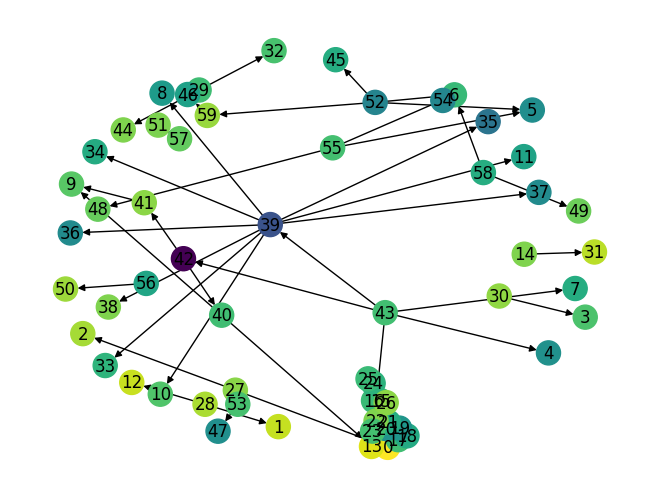

Isolated nodes: []


In [23]:
data = torch.load('/home/razvan/ML/codebert/data/processed/CWE78_OS_Command_Injection__char_connect_socket_w32_spawnvp_05.pt', weights_only=False)
if isinstance(data, Data):
    print(f'No of nodes: {data.num_nodes}')
    print(f'No of edges: {data.num_edges}')
    print(f'Label : {data.y}')
graph = to_networkx(data, to_undirected = False)
node_colors = data.x[:, 0].cpu().numpy()#data.x[:, 0].gpu().numpy() if it was loaded from gpu
nx.draw(graph, node_color=node_colors, cmap=plt.cm.viridis, with_labels=True)
plt.show()
#for node_id in graph.nodes():
#    print(node_id, data.x[node_id])
isolated_nodes = list(nx.isolates(graph))
print("Isolated nodes:", isolated_nodes)

In [24]:
torch.manual_seed(42)
extra_class = "CWE000"
if extra_class not in le.classes_:
    le.classes_ = numpy.append(le.classes_, extra_class)
class myGAT(torch.nn.Module):
    def __init__(self, feature_sz, le, params, embedding_sz = 768):
        super().__init__()
        no_classes = len(le.classes_)
        no_heads = params["no_heads"]#3
        my_drop = params["my_drop"]#0.3
        top_k_ratio1 = params["top_k_ratio1"] #0.8
        top_k_ratio2 = params["top_k_ratio2"] #0.5
        top_k_ratio3 = params["top_k_ratio3"] #0.3
        dense_neurons = params["dense_neurons"] #1024
        
        self.conv1 = torch_geometric.nn.GATConv(feature_sz, embedding_sz, heads=no_heads, dropout = my_drop)
        self.head_transform1 = torch_geometric.nn.Linear(embedding_sz * no_heads, embedding_sz)
        self.pool1 = torch_geometric.nn.TopKPooling(embedding_sz, top_k_ratio1)
        
        self.conv2 = torch_geometric.nn.GATConv(embedding_sz, embedding_sz, heads=no_heads, dropout = my_drop)
        self.head_transform2 = torch_geometric.nn.Linear(embedding_sz * no_heads, embedding_sz)
        self.pool2 = torch_geometric.nn.TopKPooling(embedding_sz, top_k_ratio2)
        
        self.conv3 = torch_geometric.nn.GATConv(embedding_sz, embedding_sz, heads=no_heads, dropout = my_drop)
        self.head_transform3 = torch_geometric.nn.Linear(embedding_sz * no_heads, embedding_sz)
        self.pool3 = torch_geometric.nn.TopKPooling(embedding_sz, top_k_ratio3)
        
        self.linear1 = torch_geometric.nn.Linear(embedding_sz*2, dense_neurons)
        self.linear2 = torch_geometric.nn.Linear(dense_neurons, int(dense_neurons/2))
        self.linear3 = torch_geometric.nn.Linear(int(dense_neurons/2), no_classes)
        
        self.bn1 = torch.nn.BatchNorm1d(embedding_sz)
        self.bn2 = torch.nn.BatchNorm1d(embedding_sz)
        self.bn3 = torch.nn.BatchNorm1d(embedding_sz)
    def forward(self, x, edge_attr, edge_index, batch_index, for_smote = 0):
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)
        x = torch.nn.functional.relu(self.bn1(x)) 
        x, edge_index, edge_attr, batch_index, _ , _ = self.pool1(x, edge_index, None, batch_index)
        #maybe x = torch.nn.functional.dropout(x, p=my_drop, training=self.training)
        x1 = torch.cat([torch_geometric.nn.global_max_pool(x, batch_index), torch_geometric.nn.global_mean_pool(x,batch_index)], dim = 1)
        
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        x = torch.nn.functional.relu(self.bn2(x)) 
        x, edge_index, edge_attr, batch_index, _ , _ = self.pool2(x, edge_index, None, batch_index)
        x2 = torch.cat([torch_geometric.nn.global_max_pool(x, batch_index), torch_geometric.nn.global_mean_pool(x,batch_index)], dim = 1)
        
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        x = torch.nn.functional.relu(self.bn3(x)) 
        x, edge_index, edge_attr, batch_index, _ , _ = self.pool3(x, edge_index, None, batch_index)
        x3 = torch.cat([torch_geometric.nn.global_max_pool(x, batch_index), torch_geometric.nn.global_mean_pool(x,batch_index)], dim = 1)
        
        x = x1+x2+x3
        
        if for_smote == 1:
            return x
        else:
            x = torch.nn.functional.dropout(torch.nn.functional.relu(self.linear1(x)), p=0.3, training=self.training)
            x = torch.nn.functional.dropout(torch.nn.functional.relu(self.linear2(x)), p=0.3, training=self.training)
            x = self.linear3(x)
            return x
            

In [25]:
le.classes_

array(['CWE114', 'CWE121', 'CWE122', 'CWE123', 'CWE124', 'CWE126',
       'CWE127', 'CWE134', 'CWE15', 'CWE176', 'CWE188', 'CWE190',
       'CWE191', 'CWE194', 'CWE195', 'CWE196', 'CWE197', 'CWE222',
       'CWE223', 'CWE226', 'CWE242', 'CWE244', 'CWE247', 'CWE252',
       'CWE253', 'CWE256', 'CWE259', 'CWE272', 'CWE273', 'CWE284',
       'CWE319', 'CWE321', 'CWE325', 'CWE327', 'CWE328', 'CWE338',
       'CWE364', 'CWE366', 'CWE367', 'CWE369', 'CWE377', 'CWE390',
       'CWE391', 'CWE398', 'CWE400', 'CWE401', 'CWE404', 'CWE415',
       'CWE416', 'CWE426', 'CWE427', 'CWE457', 'CWE459', 'CWE464',
       'CWE467', 'CWE468', 'CWE469', 'CWE475', 'CWE476', 'CWE478',
       'CWE479', 'CWE480', 'CWE481', 'CWE482', 'CWE483', 'CWE484',
       'CWE506', 'CWE510', 'CWE511', 'CWE526', 'CWE534', 'CWE535',
       'CWE546', 'CWE561', 'CWE562', 'CWE563', 'CWE570', 'CWE571',
       'CWE587', 'CWE588', 'CWE590', 'CWE591', 'CWE605', 'CWE606',
       'CWE615', 'CWE617', 'CWE620', 'CWE665', 'CWE666', 'CWE66

In [26]:
processed_files = mygraph.processed_file_names.copy()
processed_files.sort()  #only the copy is affected
train_dataset = []
test_dataset = []
common_label = []
idx = 0
comcount = 0
while idx < len(processed_files):
    file = processed_files[idx]
    count = 1
    while idx + count < len(processed_files) and processed_files[idx + count].split('_')[0] == file.split('_')[0]:
        count += 1
    if count <= 20:
        common_label.append(processed_files[idx].split('_')[0])
        comcount += count
        idx += count
        continue
    train_proc = int(round(count * 0.7))
    test_proc = count - train_proc
    print(f'trained {train_proc} | test {test_proc} | total {count} -> {file.split('_')[0]}')
    for i in range(train_proc):
        train_dataset.append(processed_files[i + idx])
    for i in range(test_proc):
        test_dataset.append(processed_files[i + idx + train_proc])
    idx += count
idx = 0
train_comcount = int(round(comcount * 0.7))
test_comcount = comcount - train_comcount
print(common_label)
print(f"trained {train_comcount}  test {test_comcount} for common_label")
while idx < len(processed_files):
    if processed_files[idx].split('_')[0] in common_label:
        if train_comcount != 0:
            train_dataset.append(processed_files[idx])
            train_comcount -= 1
        elif test_comcount != 0:
            test_dataset.append(processed_files[idx])
            test_comcount -= 1
    idx += 1
print(f'training size {len(train_dataset)}')
print(f'test size{len(test_dataset)}')

trained 319 | test 137 | total 456 -> CWE114
trained 2825 | test 1211 | total 4036 -> CWE121
trained 1753 | test 751 | total 2504 -> CWE122
trained 80 | test 34 | total 114 -> CWE123
trained 902 | test 386 | total 1288 -> CWE124
trained 680 | test 292 | total 972 -> CWE126
trained 902 | test 386 | total 1288 -> CWE127
trained 1596 | test 684 | total 2280 -> CWE134
trained 27 | test 11 | total 38 -> CWE15
trained 27 | test 11 | total 38 -> CWE176
trained 25 | test 11 | total 36 -> CWE188
trained 2394 | test 1026 | total 3420 -> CWE190
trained 1835 | test 787 | total 2622 -> CWE191
trained 638 | test 274 | total 912 -> CWE194
trained 638 | test 274 | total 912 -> CWE195
trained 479 | test 205 | total 684 -> CWE197
trained 50 | test 22 | total 72 -> CWE226
trained 50 | test 22 | total 72 -> CWE244
trained 441 | test 189 | total 630 -> CWE252
trained 479 | test 205 | total 684 -> CWE253
trained 53 | test 23 | total 76 -> CWE256
trained 53 | test 23 | total 76 -> CWE259
trained 176 | test 7

In [27]:
label_to_int = {cwe: i for i, cwe in enumerate(le.classes_)}
int_to_label = {i: cwe for cwe, i in label_to_int.items()}
SMALL_CLASS_LABEL = max(label_to_int.values())
int_to_label[SMALL_CLASS_LABEL] = "CWE000"
train_graphs = []
weight_dict = defaultdict(int)
common_label_int = {cwe : i for i, cwe in enumerate(le.classes_) if cwe in common_label}
for fname in train_dataset:
    path = os.path.join(mygraph.processed_dir, fname)
    data = torch.load(path, weights_only=False)
    if data.y in common_label_int.values():
        data.y = torch.tensor(SMALL_CLASS_LABEL, dtype=torch.long)
    data = data.cpu()
    train_graphs.append(data)
    weight_dict[data.y.item()] += 1
test_graphs = []
for fname in test_dataset:
    path = os.path.join(mygraph.processed_dir, fname)
    data = torch.load(path, weights_only=False)
    if data.y in common_label_int.values():
        data.y = torch.tensor(SMALL_CLASS_LABEL, dtype=torch.long)
    data = data.cpu()
    test_graphs.append(data)

In [28]:
print(f"{len(test_graphs)} {len(train_dataset)}")

11643 27159


In [29]:
to_remove = [label for label, freq in weight_dict.items()
             if int_to_label[label] in common_label]
for key in to_remove:
    weight_dict.pop(key)

In [30]:
for cint in common_label_int.values():
    weight_dict[cint] = -1
print(weight_dict)
print(len(weight_dict))

defaultdict(<class 'int'>, {0: 319, 1: 2825, 2: 1753, 3: 80, 4: 902, 5: 680, 6: 902, 7: 1596, 8: 27, 9: 27, 10: 25, 11: 2394, 12: 1835, 13: 638, 14: 638, 16: 479, 19: 50, 21: 50, 23: 441, 24: 479, 25: 53, 26: 53, 27: 176, 28: 25, 29: 151, 30: 106, 31: 53, 32: 50, 33: 38, 34: 38, 37: 25, 38: 25, 39: 479, 40: 101, 41: 50, 42: 38, 43: 127, 44: 399, 45: 608, 46: 213, 47: 160, 48: 97, 49: 106, 50: 266, 51: 392, 52: 25, 53: 27, 54: 38, 55: 25, 56: 25, 57: 25, 58: 189, 66: 111, 67: 49, 68: 50, 70: 25, 71: 25, 72: 63, 75: 244, 79: 24, 80: 428, 81: 53, 83: 266, 85: 172, 87: 106, 88: 63, 91: 106, 92: 160, 93: 38, 96: 532, 97: 255, 98: 319, 99: 80, 100: 80, 104: 266, 101: 2660, 107: 48, 108: 266, 109: 347, 15: -1, 17: -1, 18: -1, 20: -1, 22: -1, 35: -1, 36: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 69: -1, 73: -1, 74: -1, 76: -1, 77: -1, 78: -1, 82: -1, 84: -1, 86: -1, 89: -1, 90: -1, 94: -1, 95: -1, 102: -1, 103: -1, 105: -1, 106: -1})
110


In [32]:
for i, graph in enumerate(train_graphs):
    if graph.x.shape[0] == 0:
        print(f"Graph {i} has no nodes!")
    if graph.edge_index.shape[1] == 0:
        print(f"Graph {i} has no edges!")

In [34]:
global_params = {
    "no_heads": 3,
    "my_drop": 0.3,
    "top_k_ratio1": 0.8,
    "top_k_ratio2": 0.5,
    "top_k_ratio3": 0.3,
    "dense_neurons" :1024
}

In [35]:
example = train_graphs[0]
model = myGAT(feature_sz=example.x.shape[1], le=le, params = global_params)
model = model.to('cuda')
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{count_params(model)}')
model

12801902


myGAT(
  (conv1): GATConv(768, 768, heads=3)
  (head_transform1): Linear(2304, 768, bias=True)
  (pool1): TopKPooling(768, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(768, 768, heads=3)
  (head_transform2): Linear(2304, 768, bias=True)
  (pool2): TopKPooling(768, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(768, 768, heads=3)
  (head_transform3): Linear(2304, 768, bias=True)
  (pool3): TopKPooling(768, ratio=0.3, multiplier=1.0)
  (linear1): Linear(1536, 1024, bias=True)
  (linear2): Linear(1024, 512, bias=True)
  (linear3): Linear(512, 110, bias=True)
  (bn1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [36]:
len(weight_dict)

110

In [37]:
sample_weights = torch.tensor([1.0 / weight_dict[graph.y.item()] 
                               for graph in train_graphs], dtype=torch.float)

In [38]:
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_graphs),
    replacement=True
)
NUM_GRAPHS_BATCH = 128
train_loader = DataLoader(
    train_graphs,
    batch_size=NUM_GRAPHS_BATCH,
    sampler=sampler,
    drop_last=False
)
test_loader = DataLoader(
    test_graphs,
    batch_size=NUM_GRAPHS_BATCH,
    shuffle=False,   #True for random ordering but not weighted
    drop_last=False
)

In [39]:
SMALL_CLASS_LABEL

109

In [40]:
class_weights = torch.zeros(SMALL_CLASS_LABEL + 1, dtype = torch.float)
for k, v in weight_dict.items():
    if v!= -1:
        class_weights[k] = 1.0 / v
class_weights[class_weights > 0] /= class_weights[class_weights > 0].mean()
class_weights = class_weights.to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights, ignore_index=-1)

In [41]:
class_weights

tensor([0.2159, 0.0244, 0.0393, 0.8609, 0.0764, 0.1013, 0.0764, 0.0432, 2.5507,
        2.5507, 2.7547, 0.0288, 0.0375, 0.1079, 0.1079, 0.0000, 0.1438, 0.0000,
        0.0000, 1.3774, 0.0000, 1.3774, 0.0000, 0.1562, 0.1438, 1.2994, 1.2994,
        0.3913, 2.7547, 0.4561, 0.6497, 1.2994, 1.3774, 1.8123, 1.8123, 0.0000,
        0.0000, 2.7547, 2.7547, 0.1438, 0.6819, 1.3774, 1.8123, 0.5423, 0.1726,
        0.1133, 0.3233, 0.4304, 0.7100, 0.6497, 0.2589, 0.1757, 2.7547, 2.5507,
        1.8123, 2.7547, 2.7547, 2.7547, 0.3644, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.6204, 1.4055, 1.3774, 0.0000, 2.7547, 2.7547,
        1.0931, 0.0000, 0.0000, 0.2822, 0.0000, 0.0000, 0.0000, 2.8695, 0.1609,
        1.2994, 0.0000, 0.2589, 0.0000, 0.4004, 0.0000, 0.6497, 1.0931, 0.0000,
        0.0000, 0.6497, 0.4304, 1.8123, 0.0000, 0.0000, 0.1295, 0.2701, 0.2159,
        0.8609, 0.8609, 0.0259, 0.0000, 0.0000, 0.2589, 0.0000, 0.0000, 1.4348,
        0.2589, 0.1985], device='cuda:0'

Proceesing batch 0.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 1.....
Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesin

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 1.....
Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesin

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


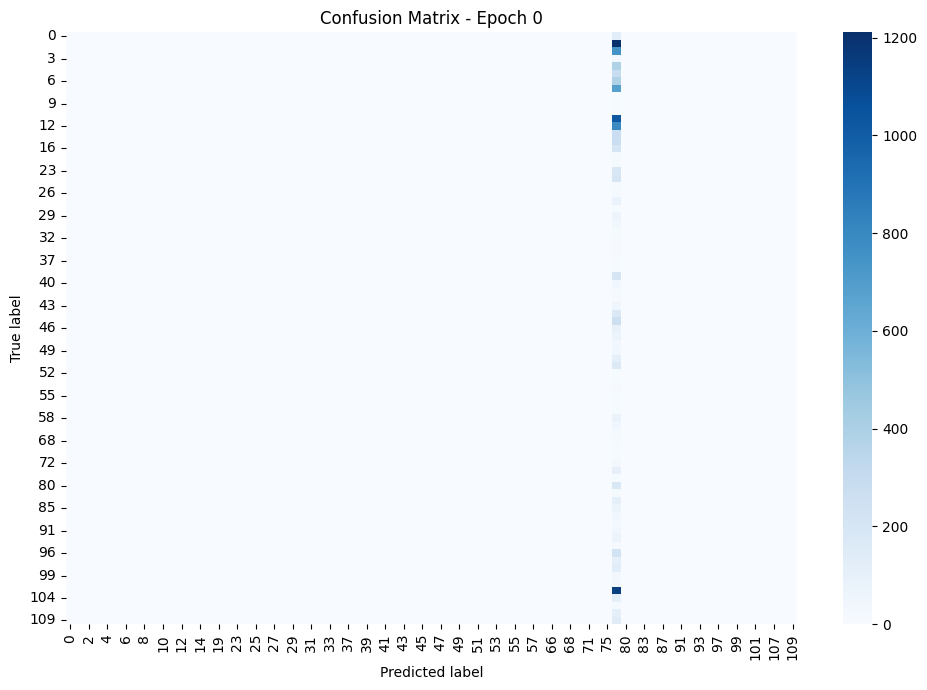

Epoch 0 - Average Loss: 5.5715
Epoch 0 | Test Loss 5.571484308976394
Proceesing batch 0.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 1.....
Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesin

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Procee

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


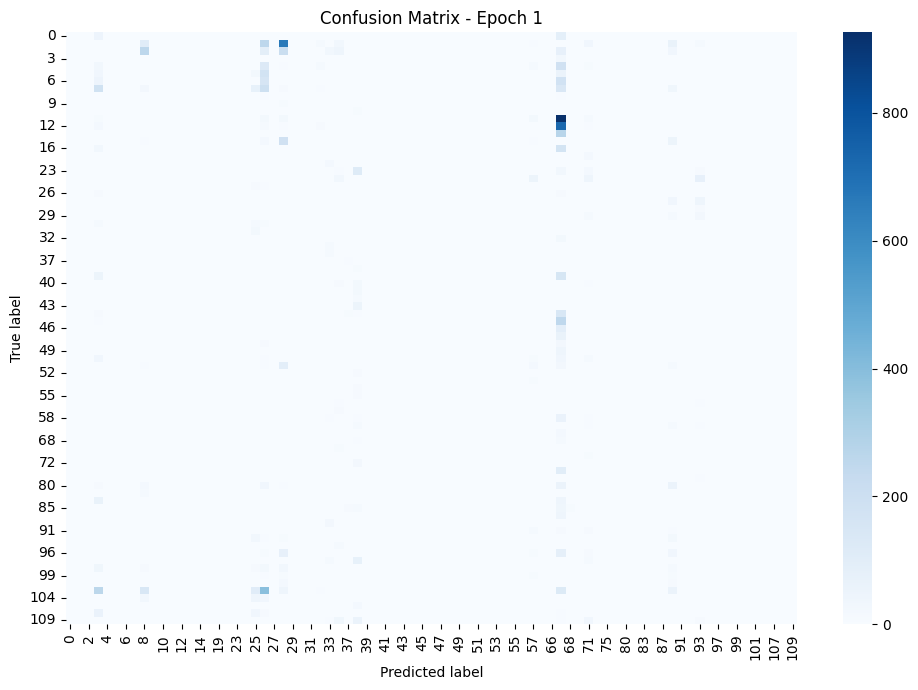

Epoch 1 - Average Loss: 5.7179
Epoch 1 | Test Loss 5.7178804612421725
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Proceesing batch 44.....
Proce

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


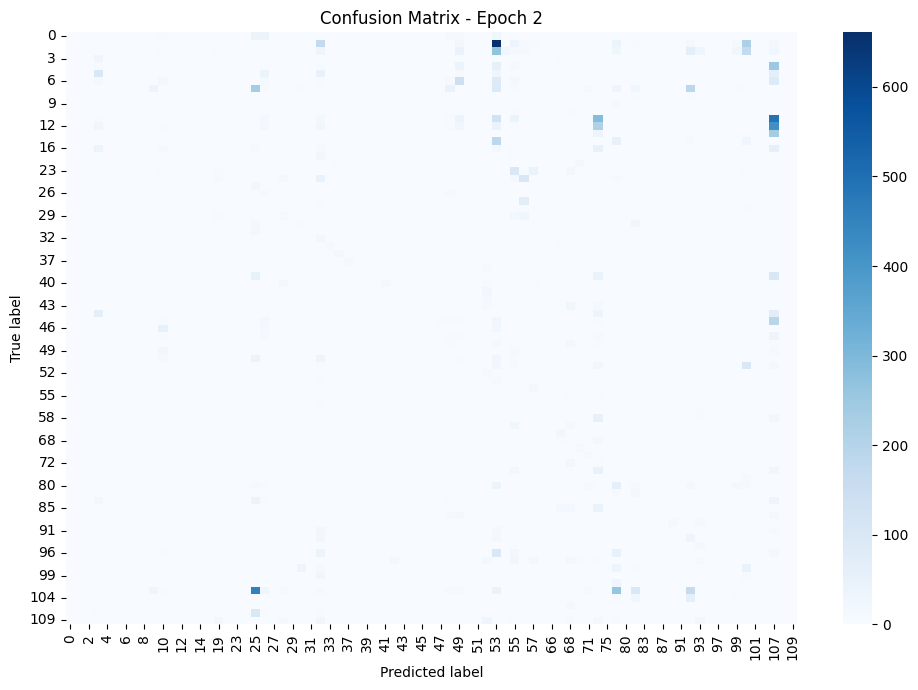

Epoch 2 - Average Loss: 5.5281
Epoch 2 | Test Loss 5.528075261430426
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Proceesing batch 44.....
Proce

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


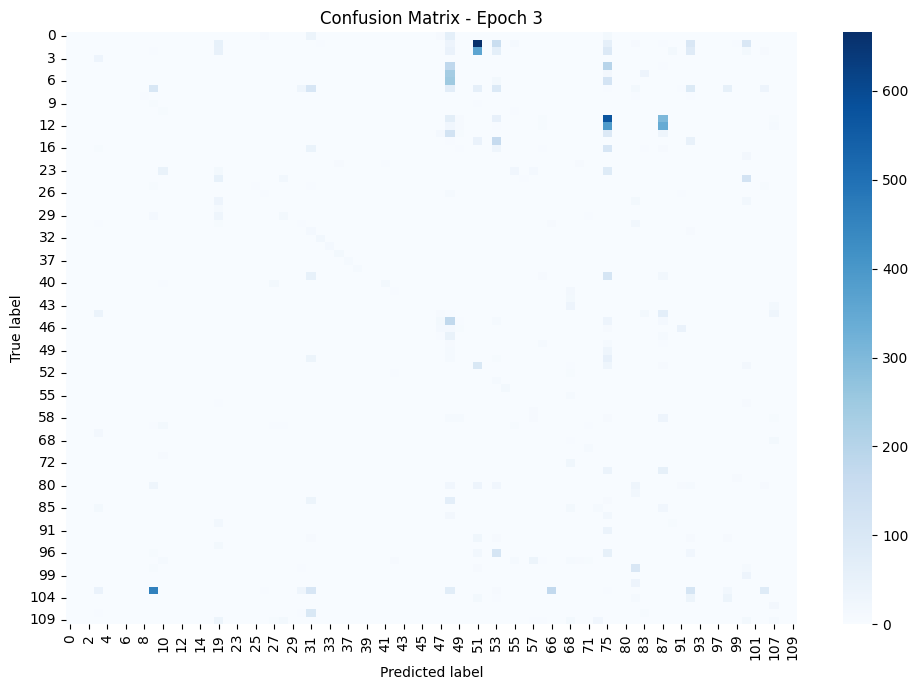

Epoch 3 - Average Loss: 4.7727
Epoch 3 | Test Loss 4.772729470507129
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Procee

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


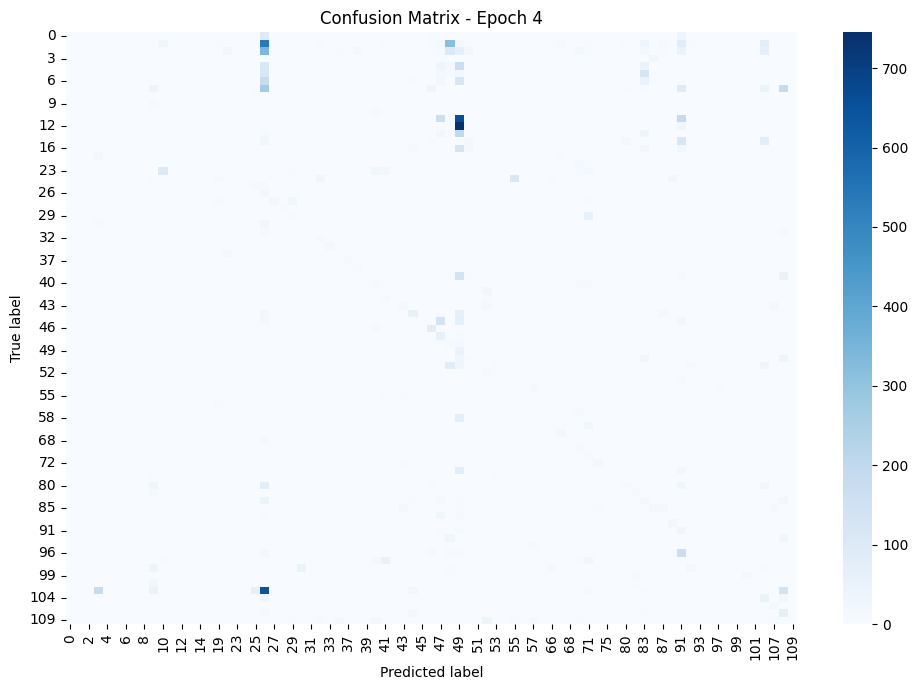

Epoch 4 - Average Loss: 4.5541
Epoch 4 | Test Loss 4.554124367106092
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Procee

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


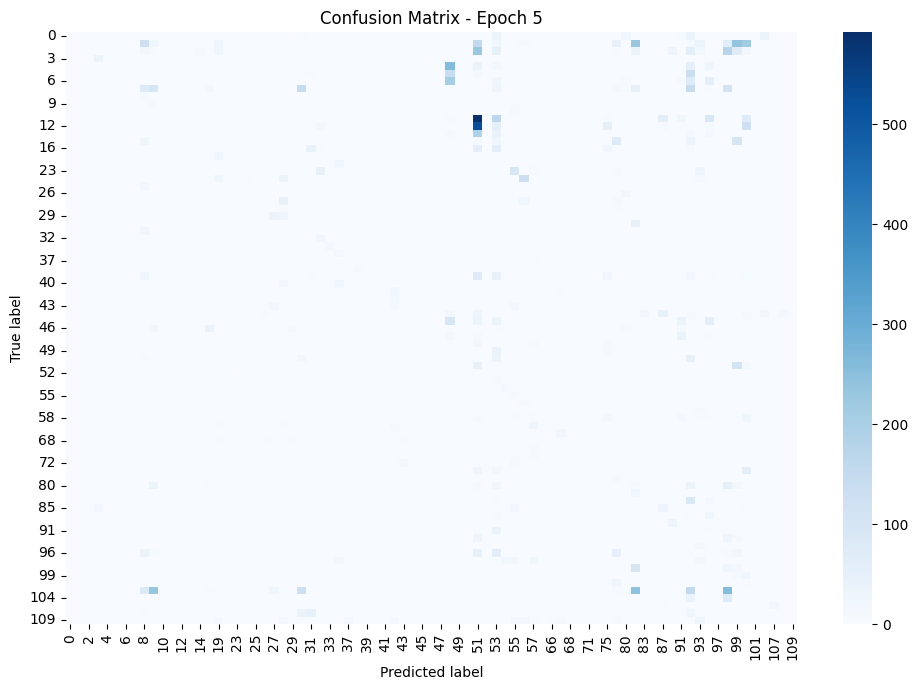

Epoch 5 - Average Loss: 5.1168
Epoch 5 | Test Loss 5.1168191236454055
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


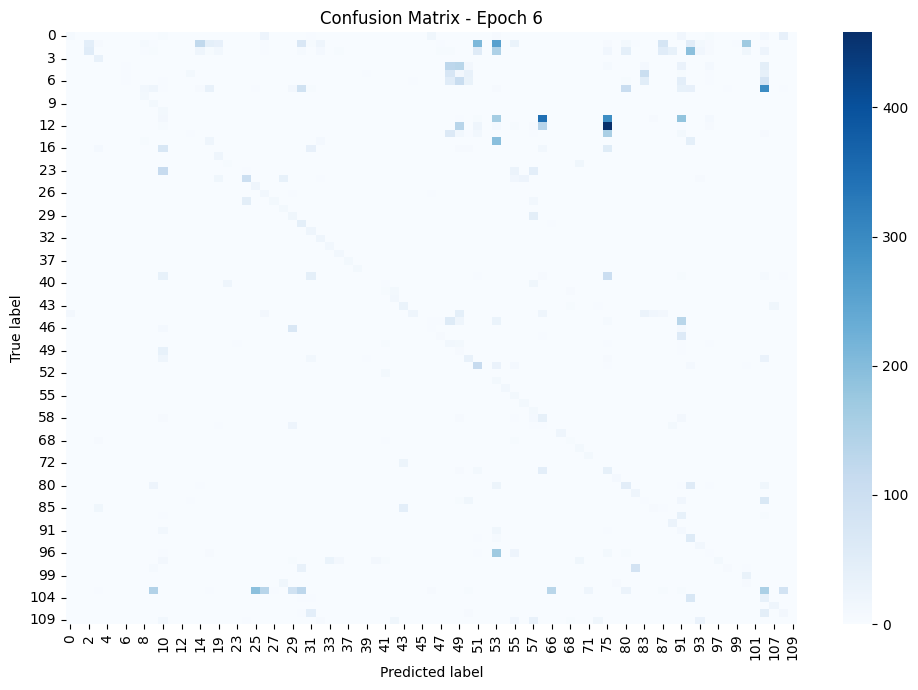

Epoch 6 - Average Loss: 3.4826
Epoch 6 | Test Loss 3.4825682646625644
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


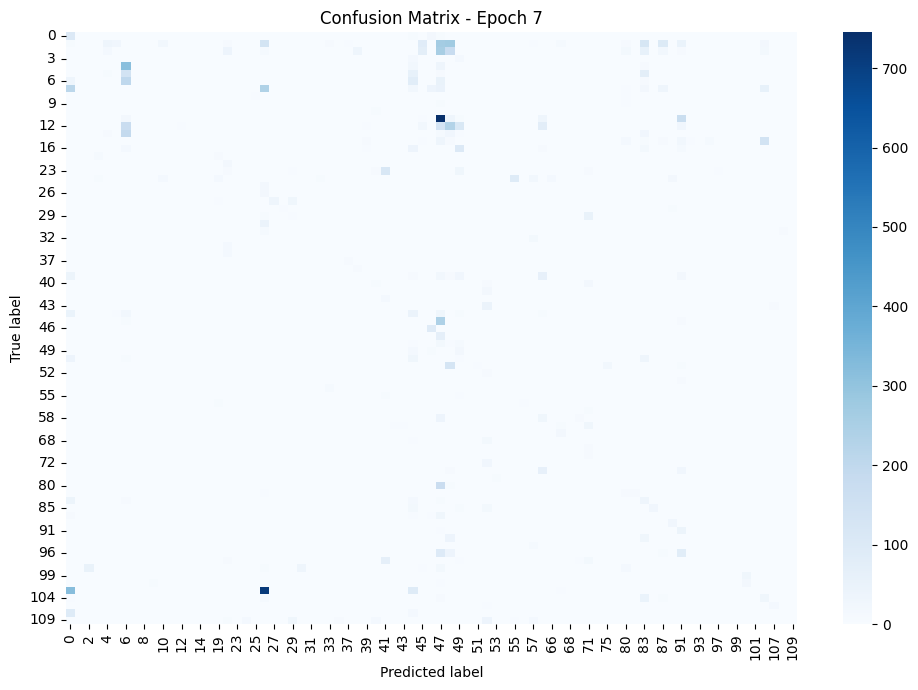

Epoch 7 - Average Loss: 4.2381
Epoch 7 | Test Loss 4.238080674065993
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


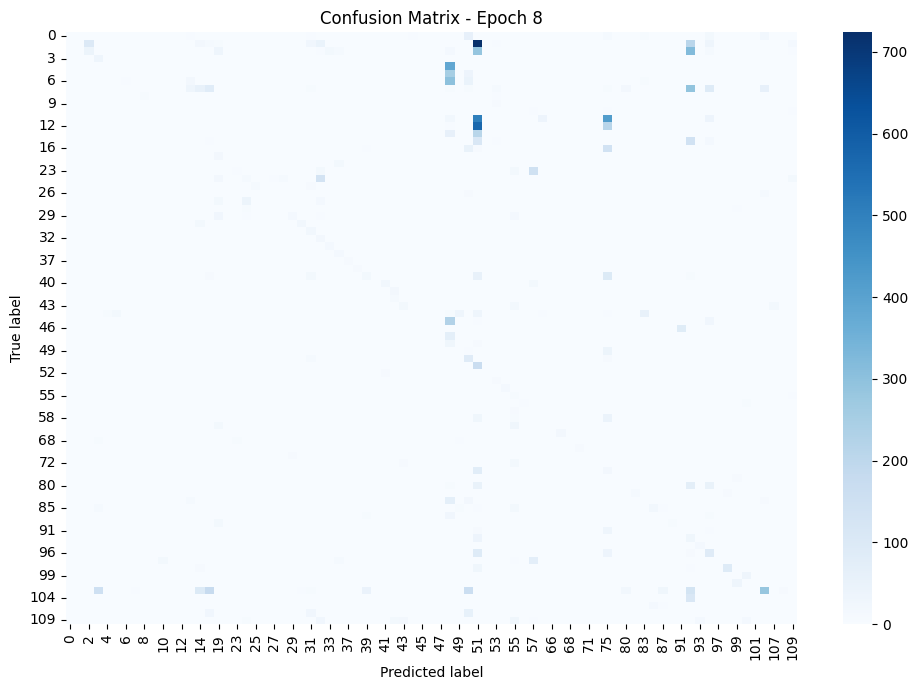

Epoch 8 - Average Loss: 4.2461
Epoch 8 | Test Loss 4.2460512930711545
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Proceesing batch 44.....
Proce

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


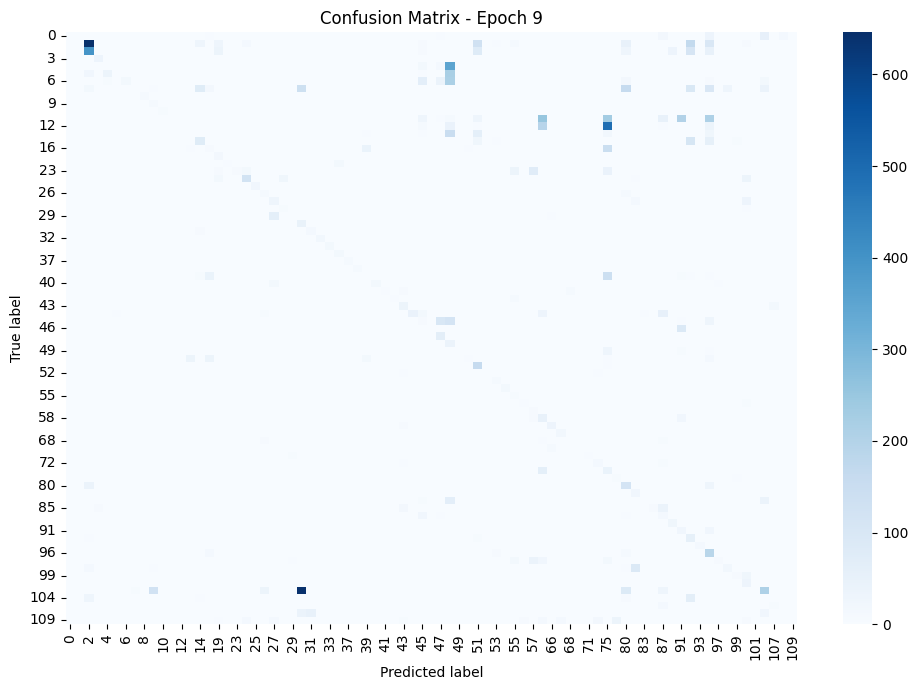

Epoch 9 - Average Loss: 3.2579
Epoch 9 | Test Loss 3.257927635213831
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Procee

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


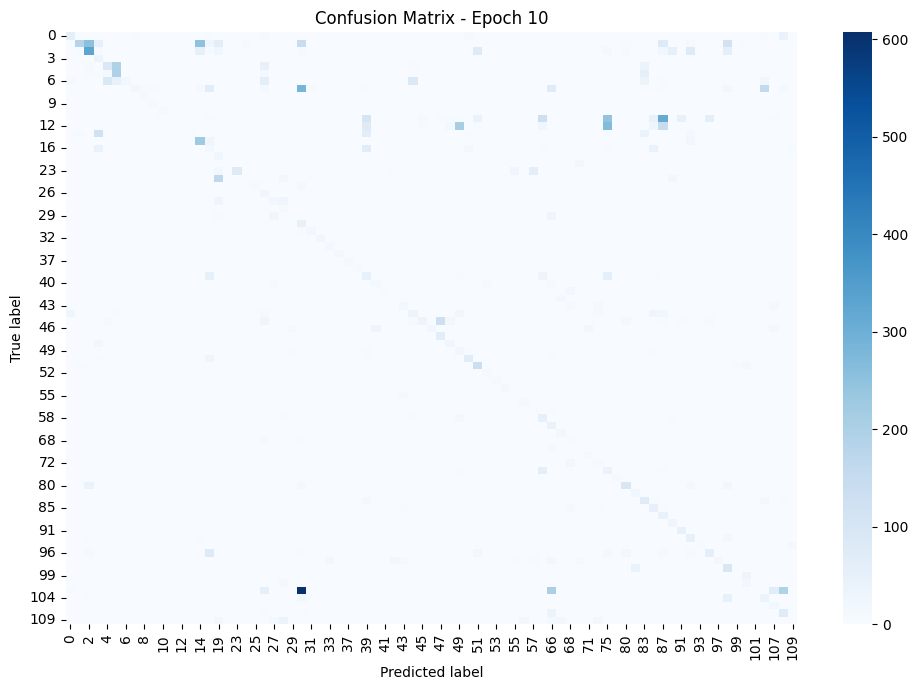

Epoch 10 - Average Loss: 2.7051
Epoch 10 | Test Loss 2.705120237155275
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


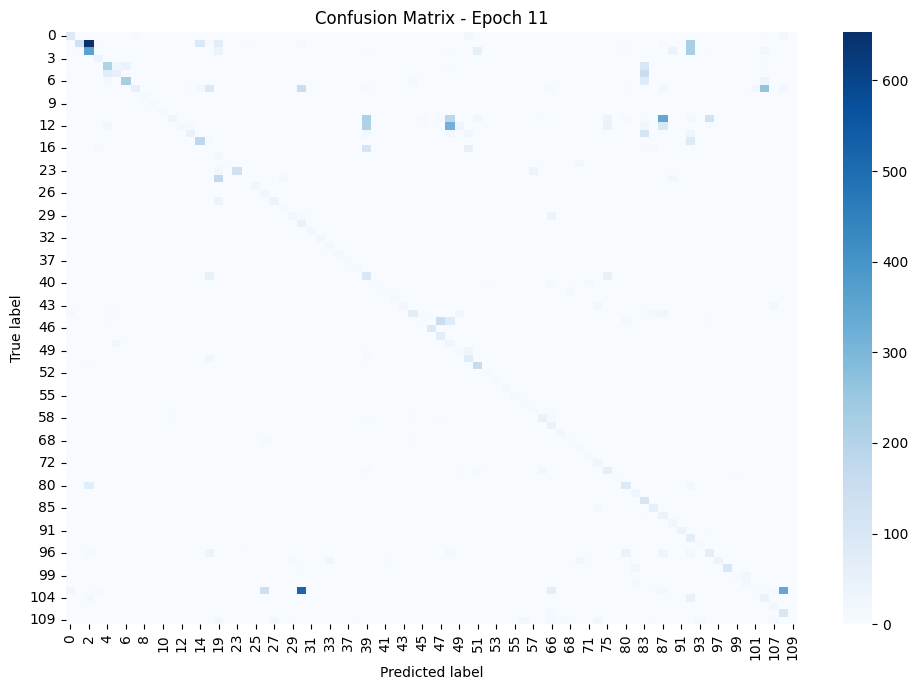

Epoch 11 - Average Loss: 2.0040
Epoch 11 | Test Loss 2.00397071234145
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Procee

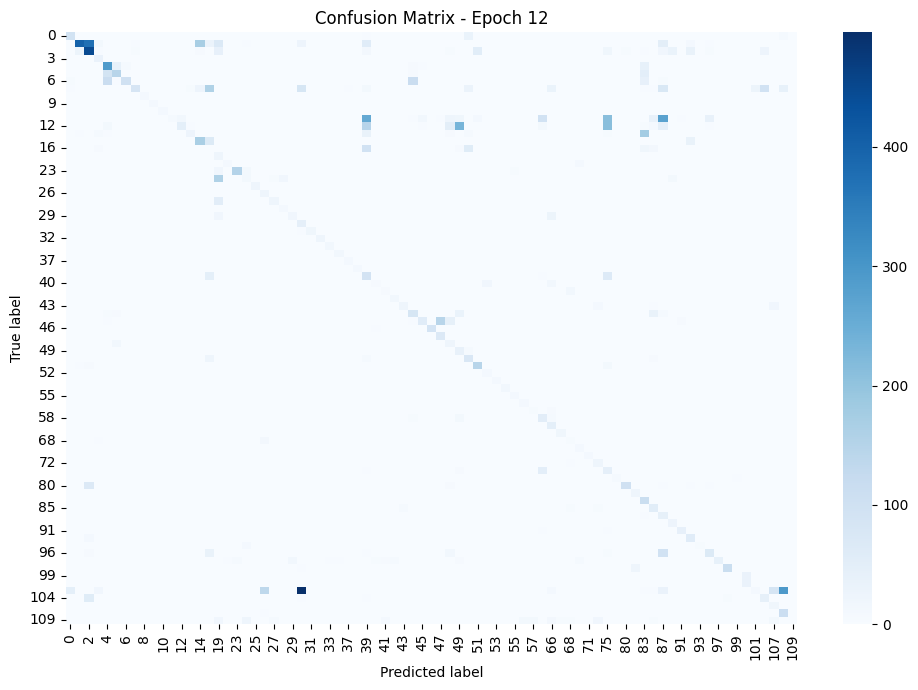

Epoch 12 - Average Loss: 1.9208
Epoch 12 | Test Loss 1.920781566792137
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Proceesing batch 44.....
Proce

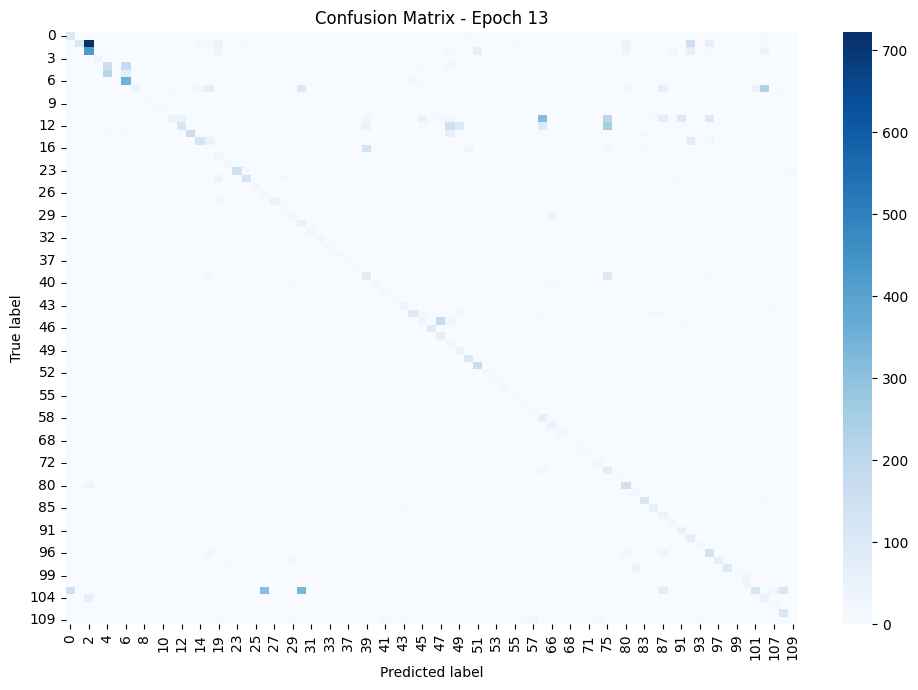

Epoch 13 - Average Loss: 1.7079
Epoch 13 | Test Loss 1.7078792144145285
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

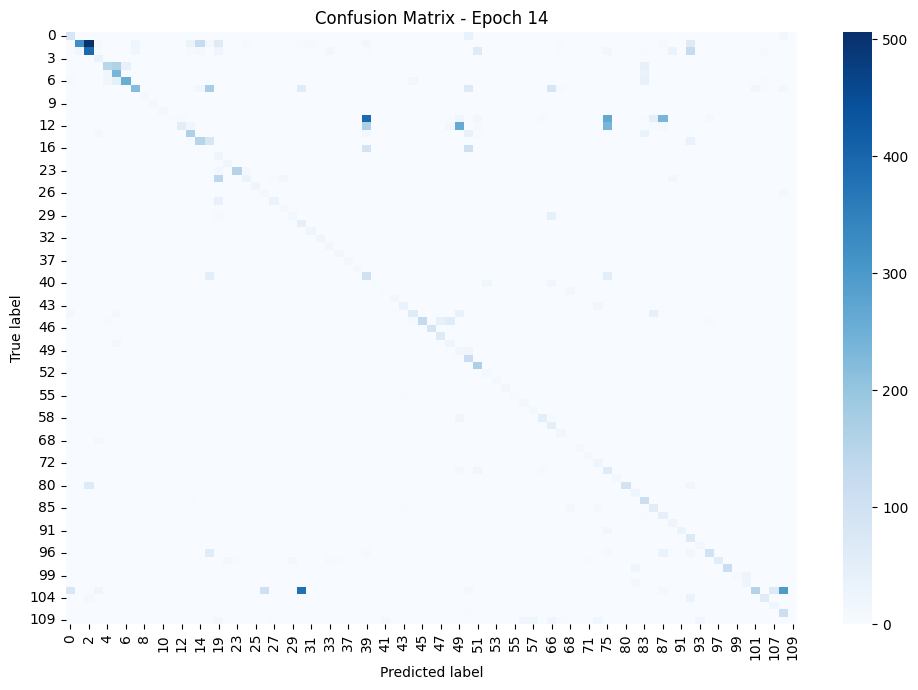

Epoch 14 - Average Loss: 1.7699
Epoch 14 | Test Loss 1.769891765337069
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

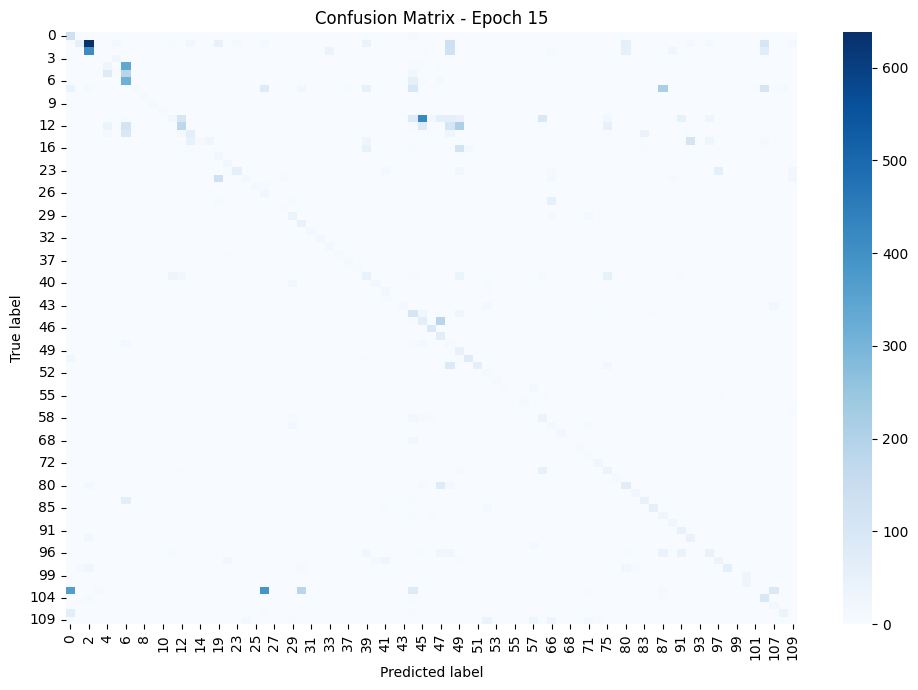

Epoch 15 - Average Loss: 2.3096
Epoch 15 | Test Loss 2.3095787839329507
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Procee

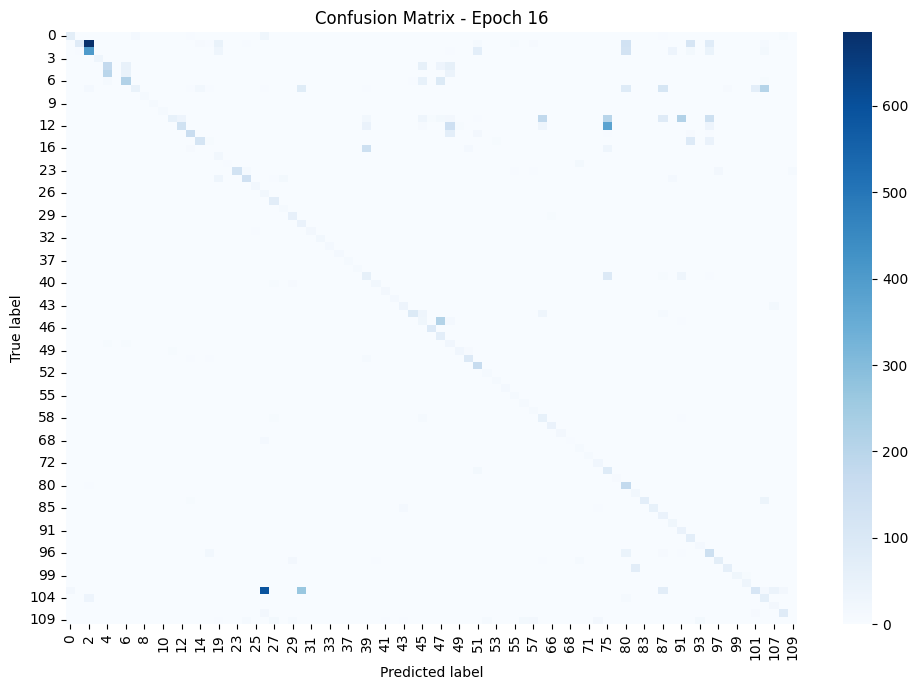

Epoch 16 - Average Loss: 1.8696
Epoch 16 | Test Loss 1.86964275695097
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Proceesing batch 44.....
Proce

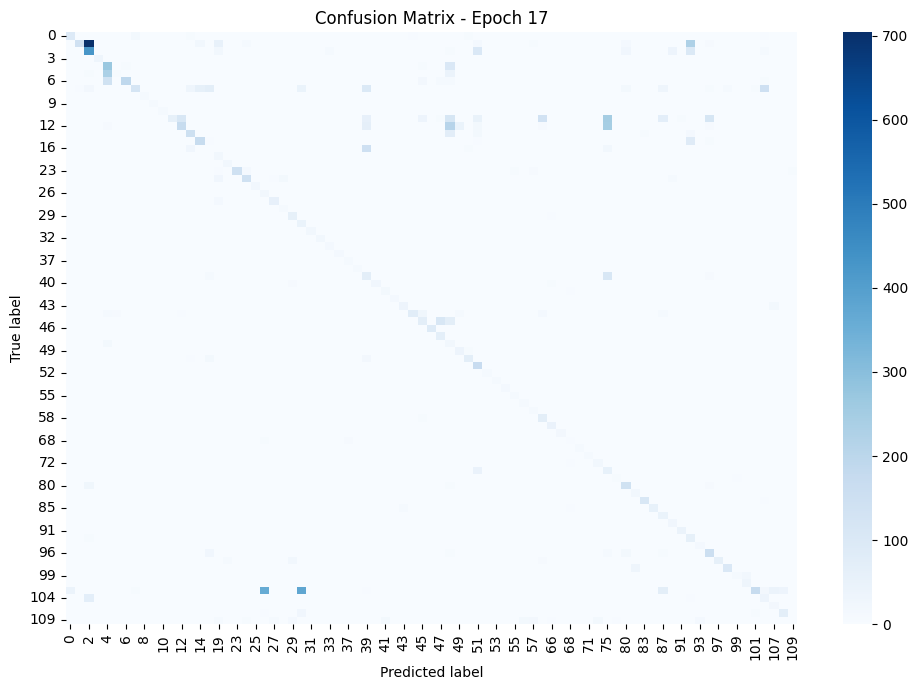

Epoch 17 - Average Loss: 1.6962
Epoch 17 | Test Loss 1.6961619906270733
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Proceesing batch 44.....
Proce

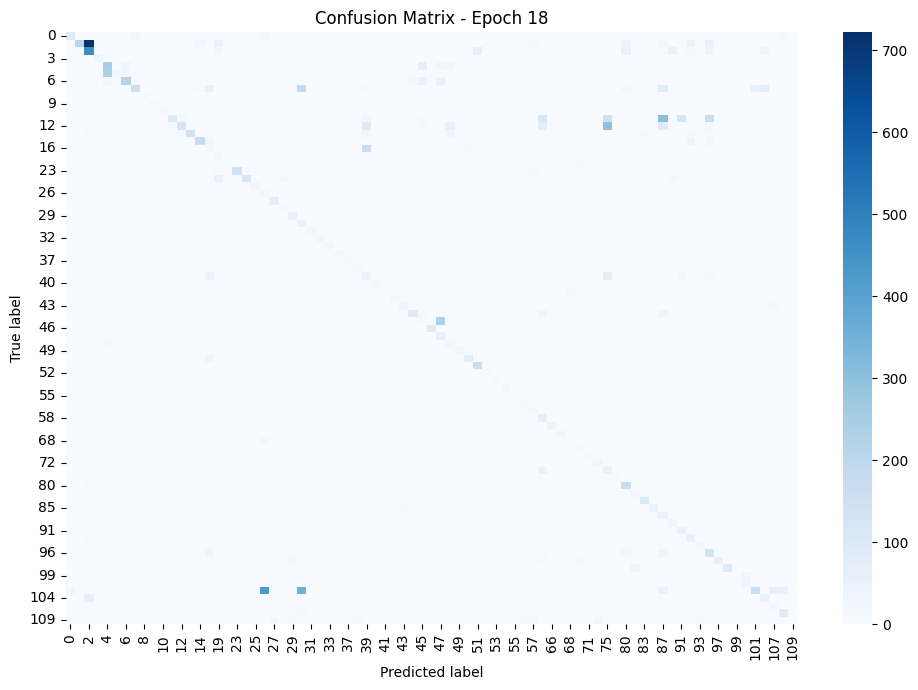

Epoch 18 - Average Loss: 1.6989
Epoch 18 | Test Loss 1.698864072336109
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Proceesing batch 44.....
Proce

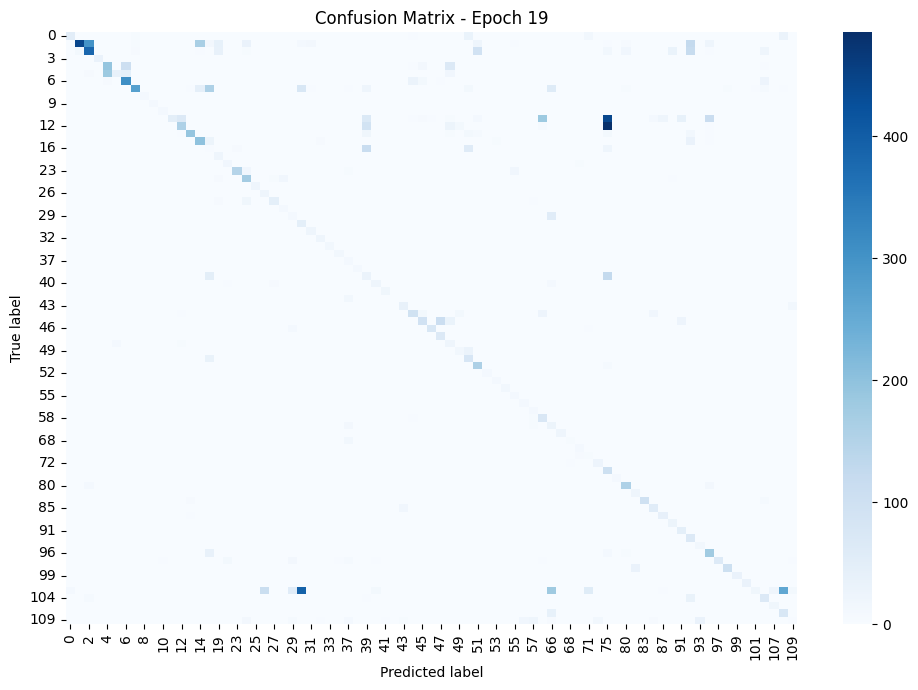

Epoch 19 - Average Loss: 1.7750
Epoch 19 | Test Loss 1.7750428628053638
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Proceesing batch 44.....
Proce

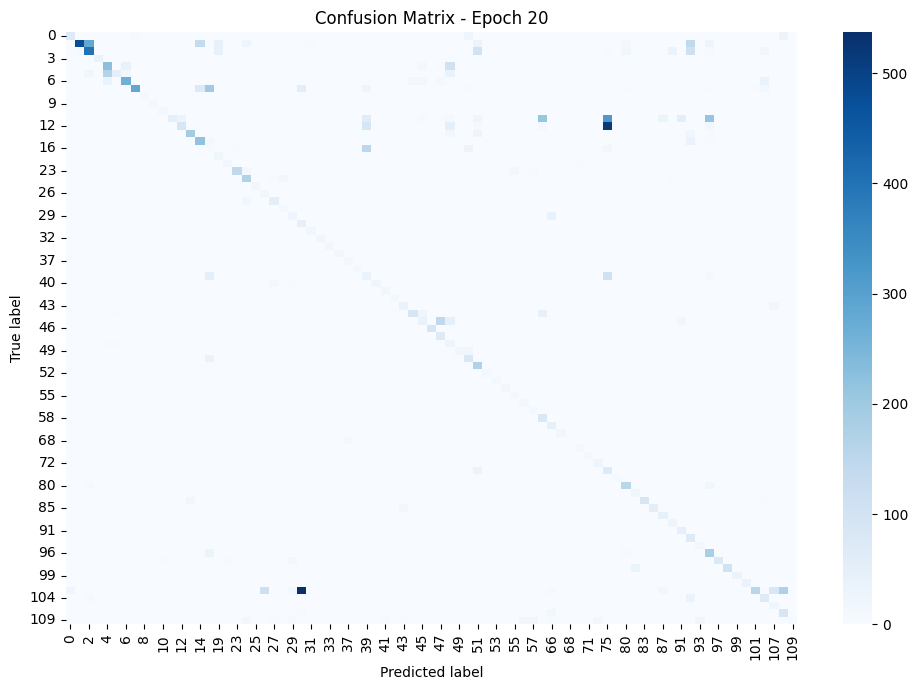

Epoch 20 - Average Loss: 1.6394
Epoch 20 | Test Loss 1.639392279733259
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Procee

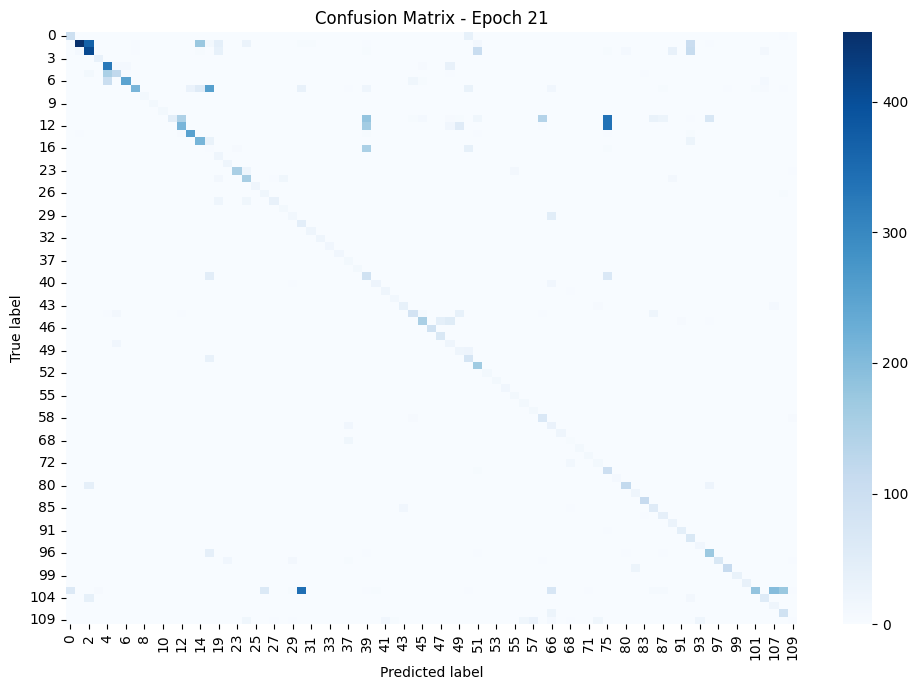

Epoch 21 - Average Loss: 1.5403
Epoch 21 | Test Loss 1.54032910954985
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

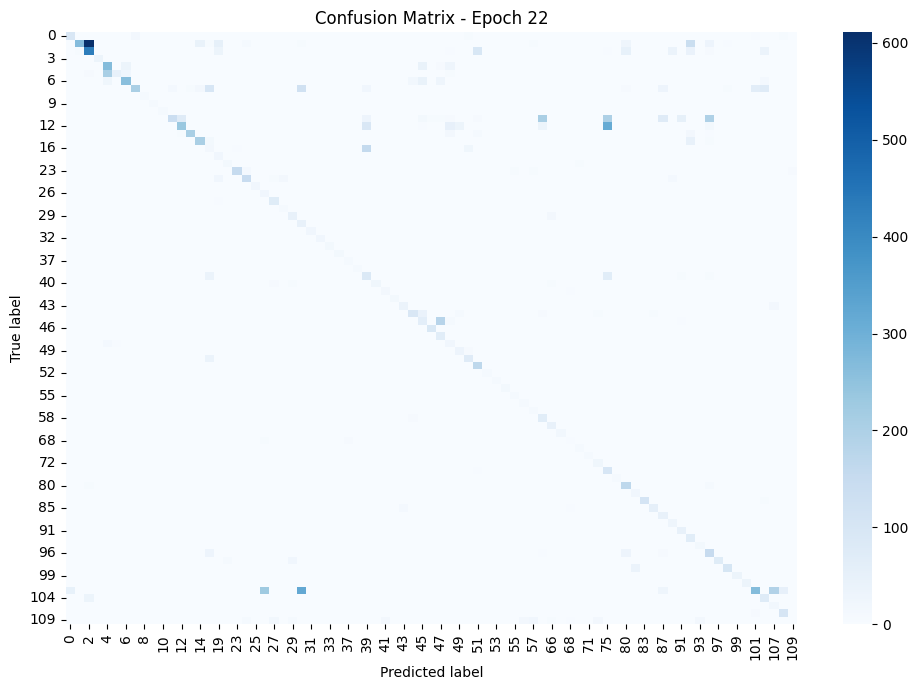

Epoch 22 - Average Loss: 1.4866
Epoch 22 | Test Loss 1.4866426190422786
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Proceesing batch 44.....
Proce

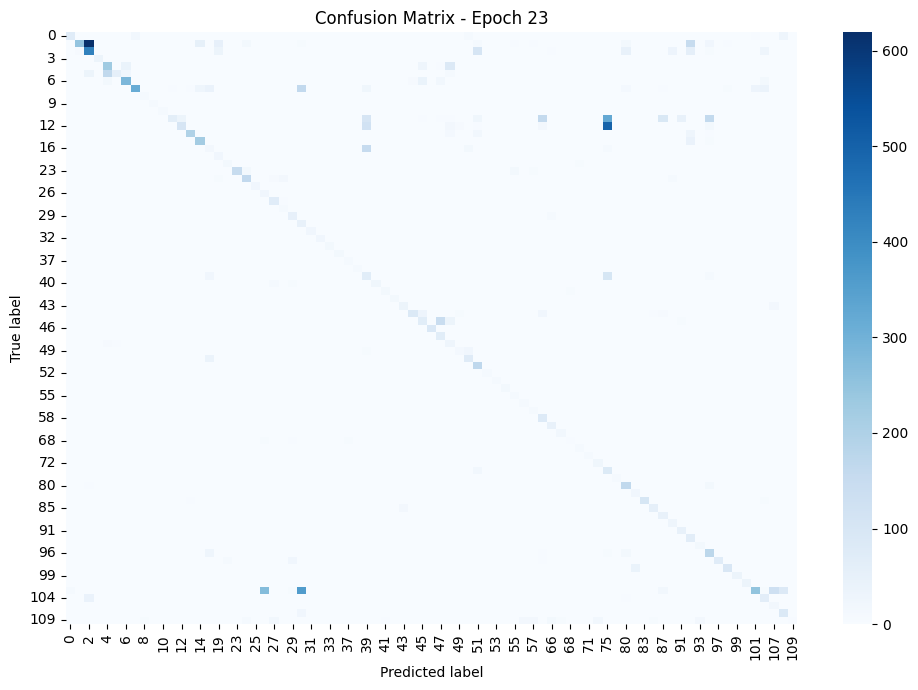

Epoch 23 - Average Loss: 1.5501
Epoch 23 | Test Loss 1.5500569946982048
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

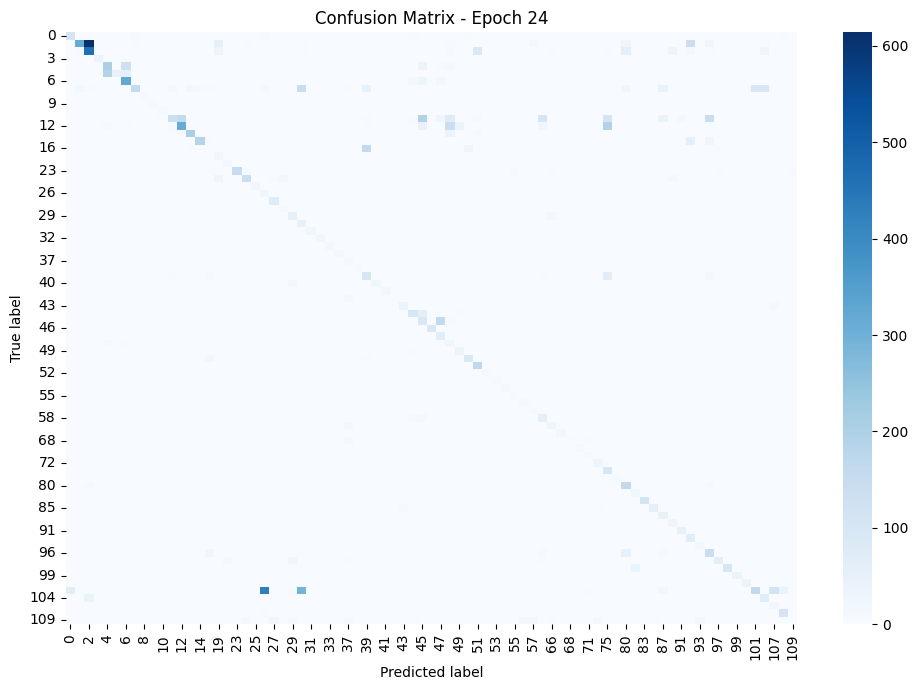

Epoch 24 - Average Loss: 1.4702
Epoch 24 | Test Loss 1.4702441980755263
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

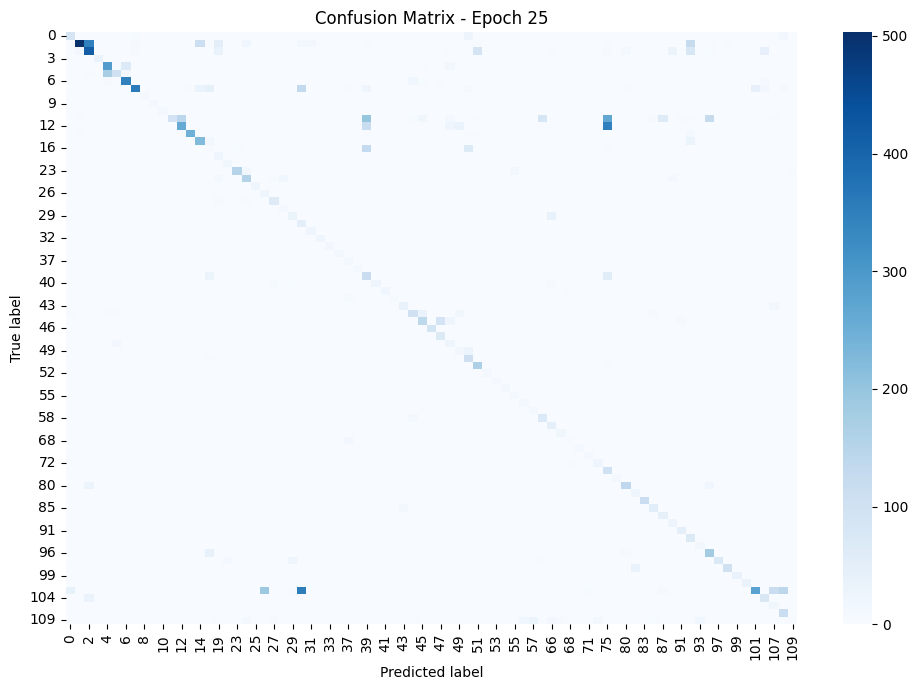

Epoch 25 - Average Loss: 1.3476
Epoch 25 | Test Loss 1.3476092279121117
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

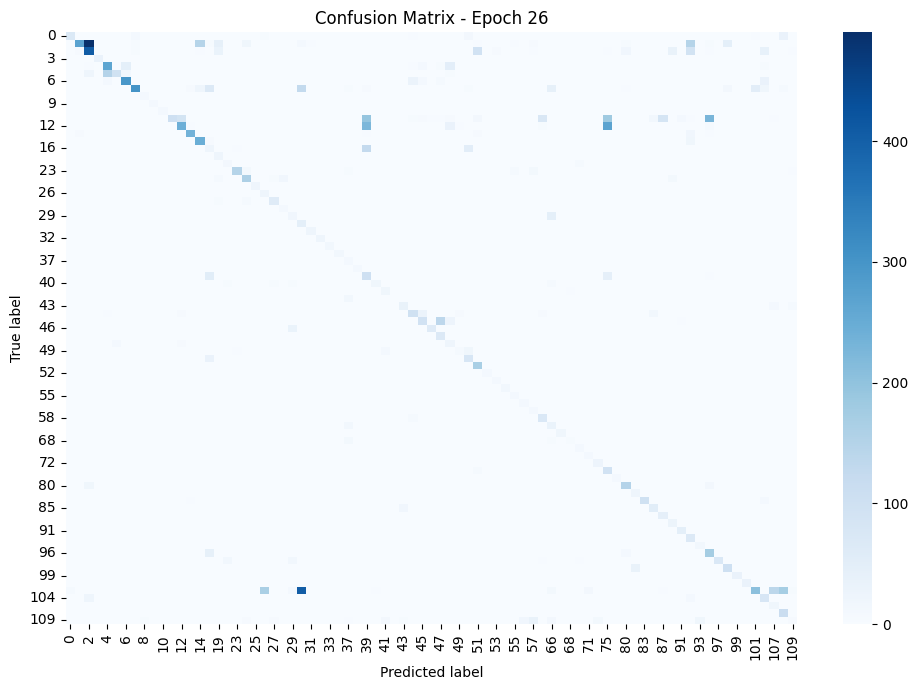

Epoch 26 - Average Loss: 1.5079
Epoch 26 | Test Loss 1.507926855461447
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Procee

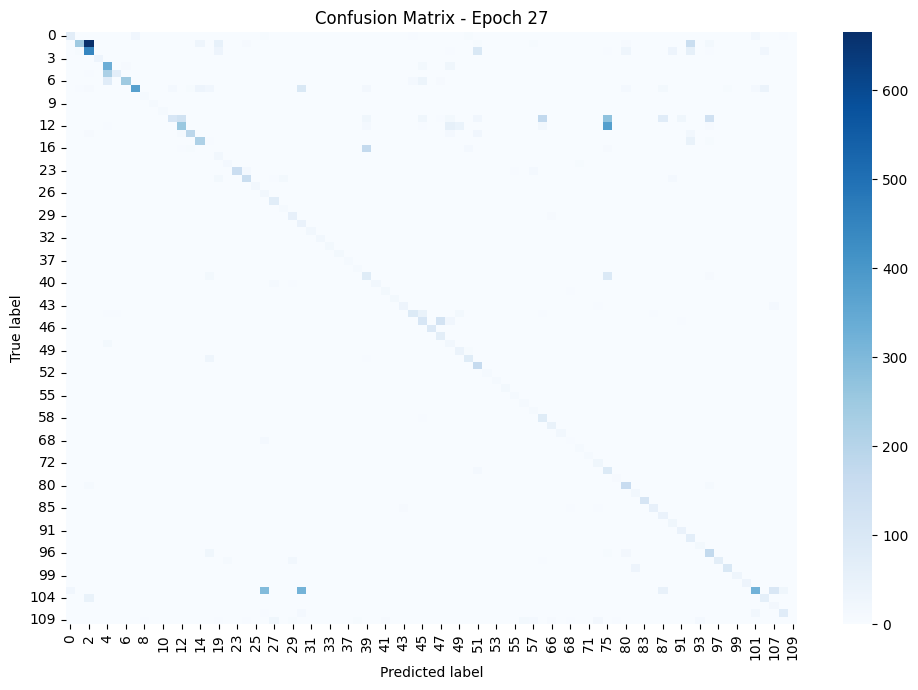

Epoch 27 - Average Loss: 1.4218
Epoch 27 | Test Loss 1.4218375883474537
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Procee

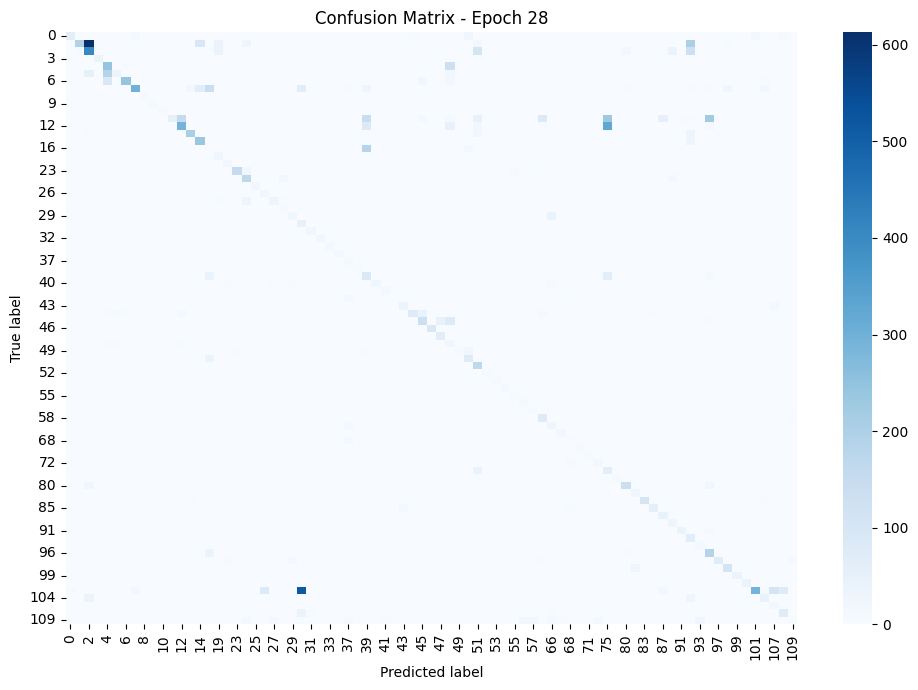

Epoch 28 - Average Loss: 1.5564
Epoch 28 | Test Loss 1.556359940607633
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Procee

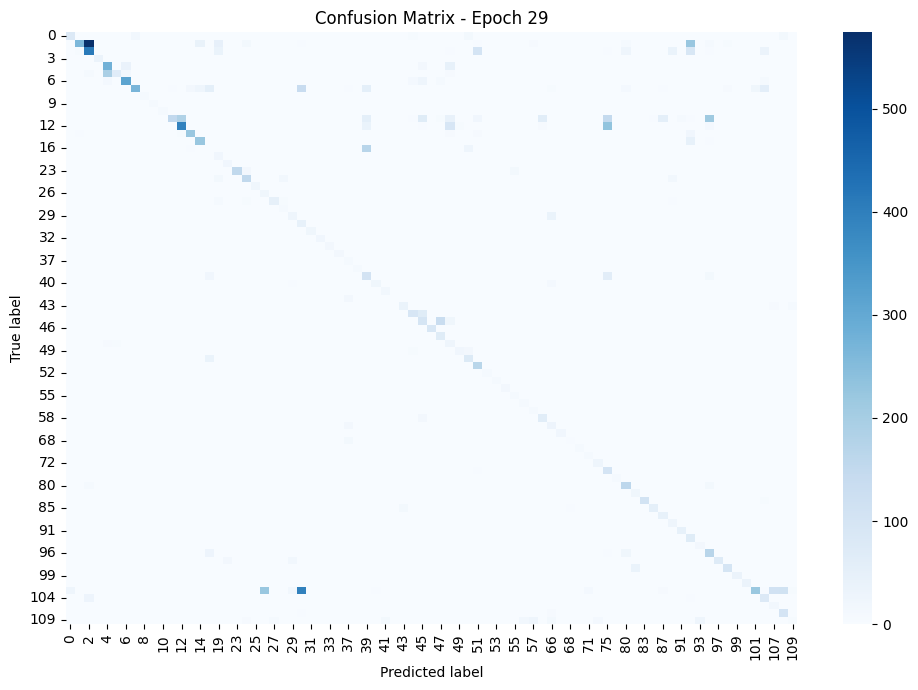

Epoch 29 - Average Loss: 1.4436
Epoch 29 | Test Loss 1.4435847661775218
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 1.....
Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesin

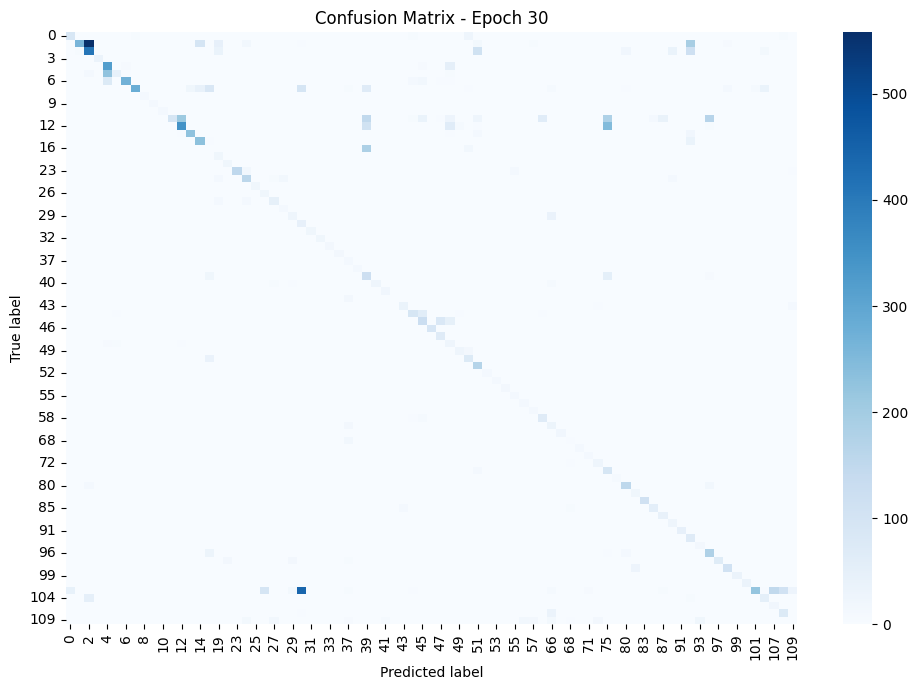

Epoch 30 - Average Loss: 1.4566
Epoch 30 | Test Loss 1.4566451753131473
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

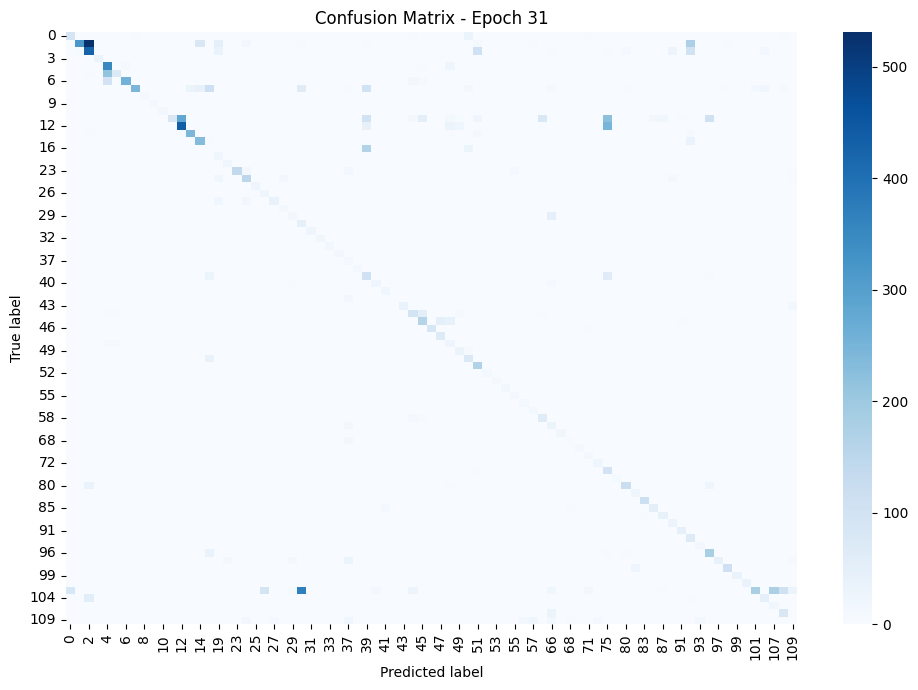

Epoch 31 - Average Loss: 1.4843
Epoch 31 | Test Loss 1.4842915987739196
Proceesing batch 0.....
Proceesing batch 1.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 2.....
Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesi

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Proceesing batch 44.....
Proce

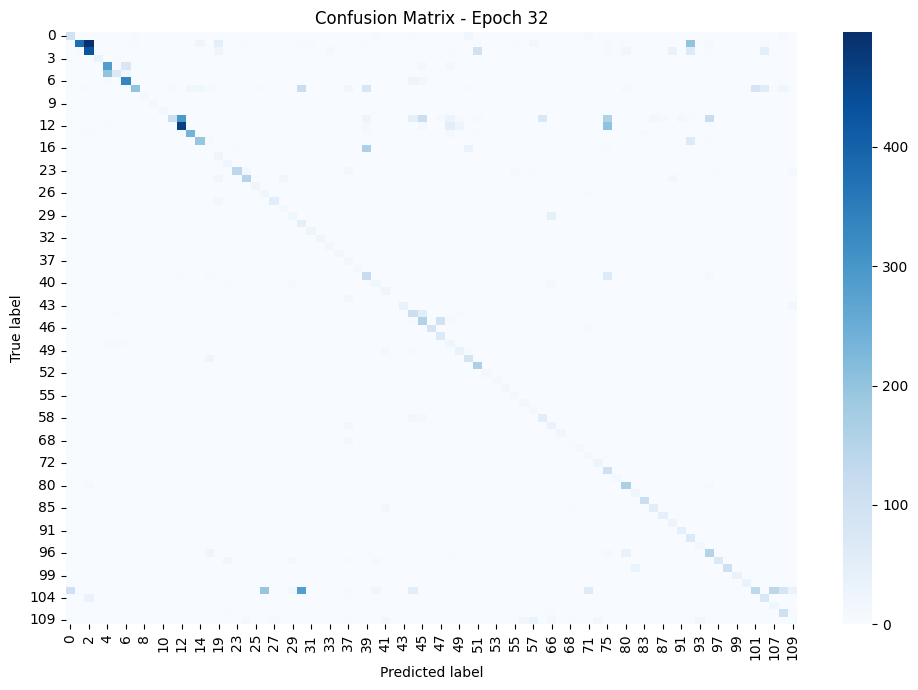

Epoch 32 - Average Loss: 1.4828
Epoch 32 | Test Loss 1.4827887779204072
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Proceesing batch 43.....
Procee

/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


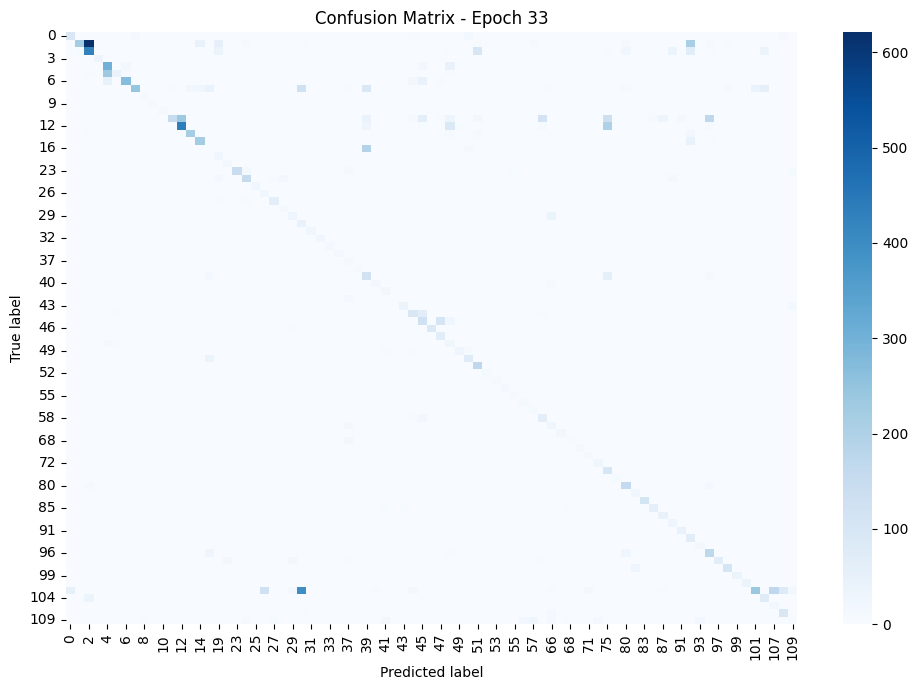

Epoch 33 - Average Loss: 1.4493
Epoch 33 | Test Loss 1.4493395362949961
Proceesing batch 0.....
Proceesing batch 1.....
Proceesing batch 2.....


/home/razvan/ML/codebert/venv/lib/python3.12/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Proceesing batch 3.....
Proceesing batch 4.....
Proceesing batch 5.....
Proceesing batch 6.....
Proceesing batch 7.....
Proceesing batch 8.....
Proceesing batch 9.....
Proceesing batch 10.....
Proceesing batch 11.....
Proceesing batch 12.....
Proceesing batch 13.....
Proceesing batch 14.....
Proceesing batch 15.....
Proceesing batch 16.....
Proceesing batch 17.....
Proceesing batch 18.....
Proceesing batch 19.....
Proceesing batch 20.....
Proceesing batch 21.....
Proceesing batch 22.....
Proceesing batch 23.....
Proceesing batch 24.....
Proceesing batch 25.....
Proceesing batch 26.....
Proceesing batch 27.....
Proceesing batch 28.....
Proceesing batch 29.....
Proceesing batch 30.....
Proceesing batch 31.....
Proceesing batch 32.....
Proceesing batch 33.....
Proceesing batch 34.....
Proceesing batch 35.....
Proceesing batch 36.....
Proceesing batch 37.....
Proceesing batch 38.....
Proceesing batch 39.....
Proceesing batch 40.....
Proceesing batch 41.....
Proceesing batch 42.....
Procees

KeyboardInterrupt: 

In [42]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import seaborn as sns
def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn, device):
    model.train()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0

    for batchidx, batch in enumerate(train_loader):
        print(f"Proceesing batch {batchidx}.....")
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x.float(), batch.edge_attr, batch.edge_index, batch.batch)
        # pred shape: [batch_size, no_classes]
        # batch.y shape: [batch_size]
        assert pred.shape[0] == batch.y.shape[0], f"Prediction shape {pred.shape} doesn't match label shape {batch.y.shape}"
        loss = loss_fn(pred, batch.y)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        step += 1
        
        with torch.no_grad():
            preds = torch.argmax(pred, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())

    all_preds = numpy.concatenate(all_preds).ravel() #concatenate goes from vector of vectors to vecotor
    all_labels = numpy.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    avg_loss = running_loss / step if step > 0 else 0
    print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}")
    return avg_loss

def test(epoch, model, test_loader, loss_fn, device):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batchidx, batch in enumerate(test_loader):
        print(f"Proceesing batch {batchidx}.....")
        batch = batch.to(device)
        pred = model(batch.x.float(), batch.edge_attr, batch.edge_index, batch.batch)
        assert pred.shape[0] == batch.y.shape[0], f"Prediction shape {pred.shape} doesn't match label shape {batch.y.shape}"
        loss = loss_fn(pred, batch.y)
        running_loss += loss.item()
        step += 1
        with torch.no_grad():
            preds = torch.argmax(pred, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())
    all_preds = numpy.concatenate(all_preds).ravel() #concatenate goes from vector of vectors to vecotor
    all_labels = numpy.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    log_conf_matrix(all_preds, all_labels, epoch)
    avg_loss = running_loss / step if step > 0 else 0
    print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}")
    return avg_loss
def calculate_metrics(all_preds, all_labels, epoch, typee):
    print(f'Confusion Matrix \n {confusion_matrix(all_labels, all_preds)}')
    print(f'F1 Score \n {f1_score(all_labels, all_preds, average='weighted')}')
    print(f'Accuracy Score \n {accuracy_score(all_labels, all_preds)}')
    print(f'Precision Score \n {precision_score(all_labels, all_preds, average='weighted')}')
    print(f'Recall Score \n {recall_score(all_labels, all_preds, average='weighted')}')
    #try:
    #    roc = roc_auc_score(all_labels, all_preds)
    #    print(f'ROC AUC: {roc}')
    #except:
    #    print('ROC AUC not defined')
'''
def log_conf_matrix(all_preds, all_labels, epoch):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    classes = le.classes_
    dataframe_cm = pd.DataFrame(conf_matrix, index=classes, columns=classes)
    plt.figure(figsize=(10, 7))
    cfm_plot = sns.heatmap(dataframe_cm, annot=True, cmap='Blues', fmt='g')
    plt.show()
    cfm_plot.figure.savefig(f'data/images/cm_{epoch}.png')
    plt.close()
'''
def log_conf_matrix(all_preds, all_labels, epoch):
    present_labels = [label for label in numpy.unique(all_labels) if label in label_to_int.values()]
    if len(present_labels) == 0:
        print(f"no labels present for epoch {epoch} skip confusion matrix.")
        return
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=present_labels)
    dataframe_cm = pd.DataFrame(conf_matrix, index=present_labels, columns=present_labels)
    plt.figure(figsize=(10, 7))
    cfm_plot = sns.heatmap(dataframe_cm, annot=False, cmap='Blues', fmt='g')
    plt.title(f"Confusion Matrix - Epoch {epoch}")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()
    #cfm_plot.figure.savefig(f"data/images/cm_{epoch}.png")
    plt.close()

def run_one_training(train_loader, test_loader, model, loss_fn):
    params = {
        "learning_rate": 0.04,
        "sgd_momentum": 0.9,
        "weight_decay": 1e-5,
        "scheduler_gamma": 0.9
    }
    optimizer = torch.optim.SGD(model.parameters(), 
                                    lr=params["learning_rate"],
                                    momentum=params["sgd_momentum"],
                                    weight_decay=params["weight_decay"])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params["scheduler_gamma"])
    best_loss = 1000
    early_stopping_counter = 0
    for epoch in range(300):
        if early_stopping_counter <= 10:
            loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn, device)
            print(f"Epoch {epoch} | Train Loss {loss}")
            #if epoch % 5 == 0:
            loss = test(epoch, model, test_loader, loss_fn, device)
            print(f"Epoch {epoch} | Test Loss {loss}")
            if float(loss) < best_loss:
                best_loss = loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            scheduler.step()
        else:
            print('Stopped because no improvement discovered')
            break
    print(f"Finishing training with best test loss: {best_loss}")
    return [best_loss]
run_one_training(train_loader, test_loader, model, loss_fn)